In [1]:
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import napari
import pickle

In [2]:
from skimage import data
from scipy import stats
from scipy import signal
from tifffile import tifffile
from os.path import sep
from matplotlib import pyplot as plt
import math
import matplotlib.colors as colors
import xarray as xr
import pandas as pd
import seaborn as sns
import json
import os

In [3]:
from fly2p_function_TQ.imaging_2p_preprocessing import combine_single_tiff, computeMotionShift, motionCorrection, low_pass_filter_TQ, high_pass_filter_TQ, averaging_frame
from fly2p_function_TQ.imaging_2p_preprocessing import combine_PB_corresponding_ROI,get_raw_F,get_dff_array, normalizing_dff_array
from fly2p_function_TQ.imaging_2p_PVA_functions import PVA_radian_calcul, PVAangleToRoi, PVA_radian_to_angle, PVA_angle_to_radian, calcualteBumpAmplitude
from fly2p_function_TQ.imaging_2p_fictrac_imaging_alignment import downsample_heading_to_total_volume, offset_calculation,fictrack_signal_decoding,moving_wrapped_plot_by_offset

In [4]:
#Just used for reading single tiff file
#image = tifffile.imread("/home/tianhaoqiu/Documents/GitHub/2p_analysis/combine_TSeries-60D05-GCaMP8s-TSeries-11242022-1355-009.tiff")
#print(image.shape)

In [5]:
#Some key parameters for imaging analysis (for futuure should come from direct reading of metadata file)
volume_cycle = 2166
volume_time = 0.13851
volume_rate = 1/volume_time
slice_per_volume = 9
fictrack_sampling_rate = 50000

In [6]:
time_array_imaging = np.arange(volume_cycle)/volume_rate

In [7]:
image_data_combined, tiff_file_sequence = combine_single_tiff(slice_num = slice_per_volume, cycle_num = volume_cycle, file_dir = '/home/tianhaoqiu/Desktop/TQfly028-006')
image = image_data_combined
image.shape

(2166, 9, 209, 379)

In [8]:
#viewer = napari.Viewer()
#new_layer = viewer.add_image(image)
#viewer.dims.ndisplay = 3

In [9]:
imgStack = xr.DataArray(image,dims = ['volumes [s]', 'planes [µm]', 'xpix [µm]', 'ypix [µm]'])

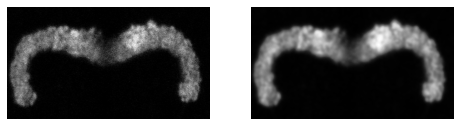

In [10]:
## Motion Correction setup
# Set reference image
stackMP = np.max(imgStack, axis=1) # max projection over volume
# Generate reference image
reference_num = np.int_(np.round(0.1 * volume_cycle))
refImg = np.mean(stackMP[0:reference_num,:,:],axis=0)

from scipy.ndimage.filters import gaussian_filter
refImgFilt = gaussian_filter(refImg, sigma=2)

fig, axs = plt.subplots(1,2,figsize=(8,4))
axs[0].imshow(refImg,cmap='Greys_r', origin='lower'); axs[0].axis('off');
axs[1].imshow(refImgFilt,cmap='Greys_r', origin='lower'); axs[1].axis('off');


perform motion correction on a single plane/max projection


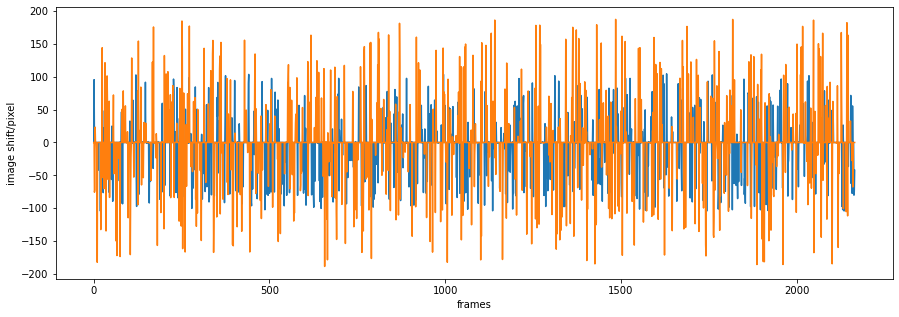

In [11]:
shift = computeMotionShift(stackMP, refImg, 10, 2, doFilter=False, stdFactor=4, showShiftFig=True)

In [12]:
stack4dMC = motionCorrection(imgStack, shift)

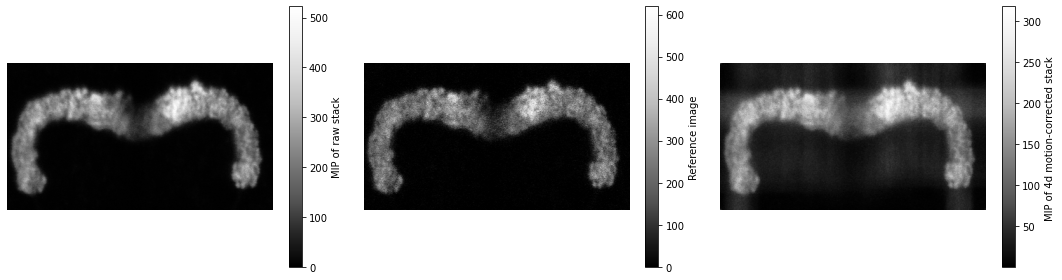

In [13]:
fig, axs = plt.subplots(1,3,figsize=(15,4))
cb = axs[0].imshow(imgStack.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[0], label='MIP of raw stack')
axs[0].axis('off');
cb = axs[1].imshow(refImg,cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[1], label='Reference image')
axs[1].axis('off');
cb = axs[2].imshow(stack4dMC.max(axis=1).mean(axis=0),cmap='Greys_r', origin='lower')
plt.colorbar(cb, ax=axs[2], label='MIP of 4d motion-corrected stack ')
axs[2].axis('off');
fig.tight_layout()

In [14]:
#new_layer = viewer.add_image(image[:,4,:,:])

In [15]:
#viewer.layers.save('my_file.csv')

In [16]:
stack4dMC.shape

(2166, 9, 209, 379)

In [17]:
from tifffile import imsave
imsave('combine_TQfly028-006.tiff',imgStack)

In [18]:
label = tifffile.imread("/home/tianhaoqiu/Documents/GitHub/2p_analysis/napari_roi/delta_7_PB/ROI_16_combine_TQfly028-006 mean-proj.tif")
#viewer.add_labels(label, name='Labels_16_Roi')

In [19]:
#Load ROI and label from napari
#napari_roi_16 = viewer.layers['Labels_16_Roi'].data
napari_roi = label[0,:,:,:]

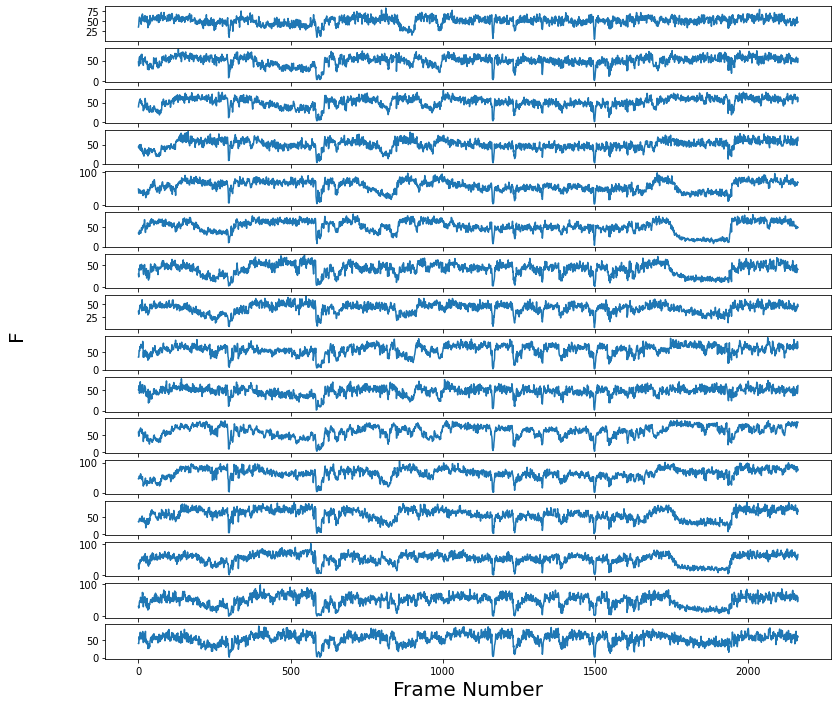

In [20]:
ROI_total = 16
F_array = get_raw_F(ROI_total, napari_roi, imgStack)

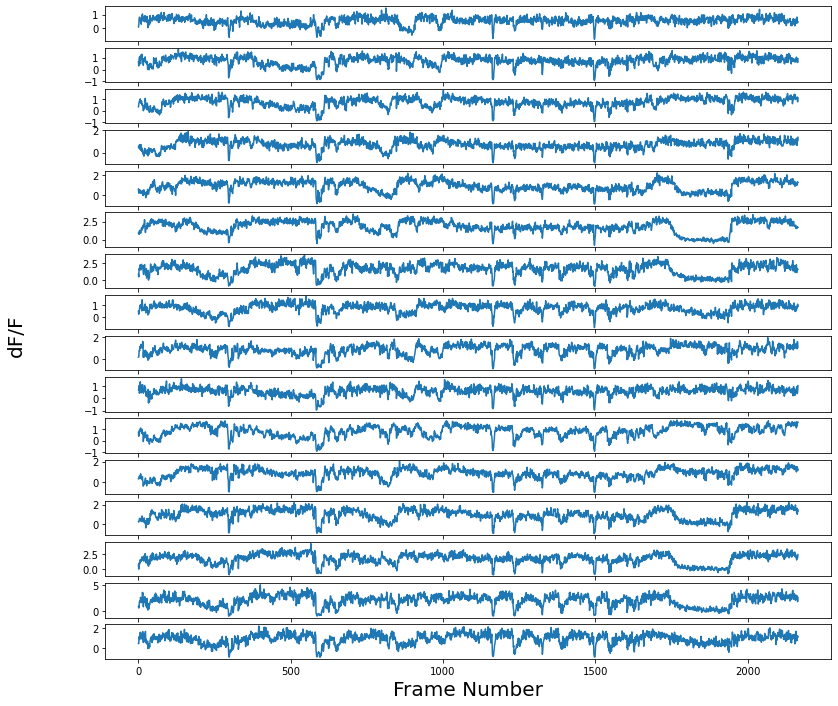

In [21]:
dF_F_array = get_dff_array(raw_F_array = F_array, ROI_num = ROI_total, F_zero_cutoff = 0.05)

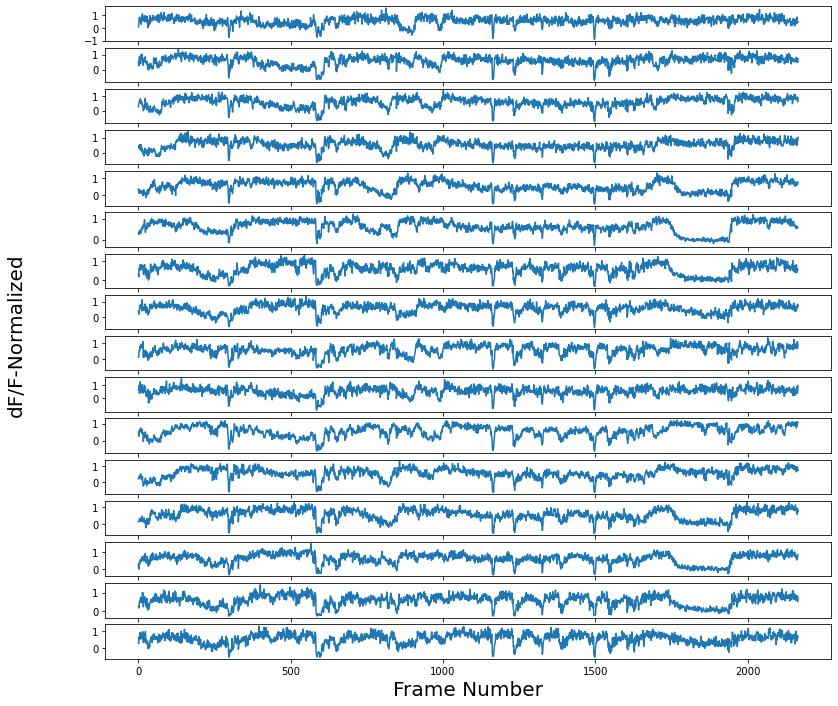

In [22]:
dF_F_array_normalized = normalizing_dff_array(dF_F_array,ROI_num= ROI_total, normalize_cutoff= 0.95)

In [25]:
#Median_filtering the normalized df_f trace
for i in range (ROI_total):
    dF_F_array_normalized[:,i] = signal.medfilt(dF_F_array_normalized[:,i],kernel_size =3)
    

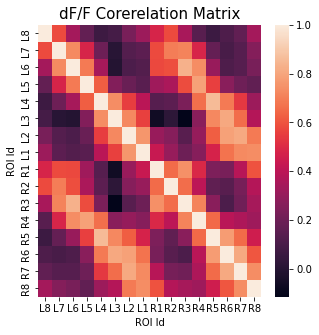

In [26]:
#Create a correlation matrix to look at the correlation between corresponding golemuruli in left/right PB
df_f_dataframe = pd.DataFrame(dF_F_array, columns=['L8', 'L7', 'L6','L5','L4','L3','L2','L1','R1','R2','R3','R4','R5','R6','R7','R8'])
correlation_matrix_df_f = df_f_dataframe.corr()
plt.figure(figsize= (5,5))
sns.heatmap(correlation_matrix_df_f)
plt.xlabel('ROI Id', fontsize=10)
plt.ylabel('ROI Id', fontsize=10)
plt.title('dF/F Corerelation Matrix', fontsize=15)
plt.show()

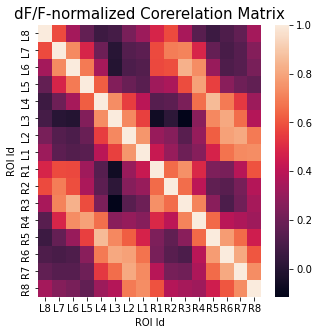

In [27]:
#Create a correlation matrix to look at the correlation between corresponding golemuruli in left/right PB
df_f_dataframe_normalized = pd.DataFrame(dF_F_array_normalized, columns=['L8', 'L7', 'L6','L5','L4','L3','L2','L1','R1','R2','R3','R4','R5','R6','R7','R8'])
correlation_matrix_df_f = df_f_dataframe.corr()
plt.figure(figsize= (5,5))
sns.heatmap(correlation_matrix_df_f)
plt.xlabel('ROI Id', fontsize=10)
plt.ylabel('ROI Id', fontsize=10)
plt.title('dF/F-normalized Corerelation Matrix', fontsize=15)
plt.show()

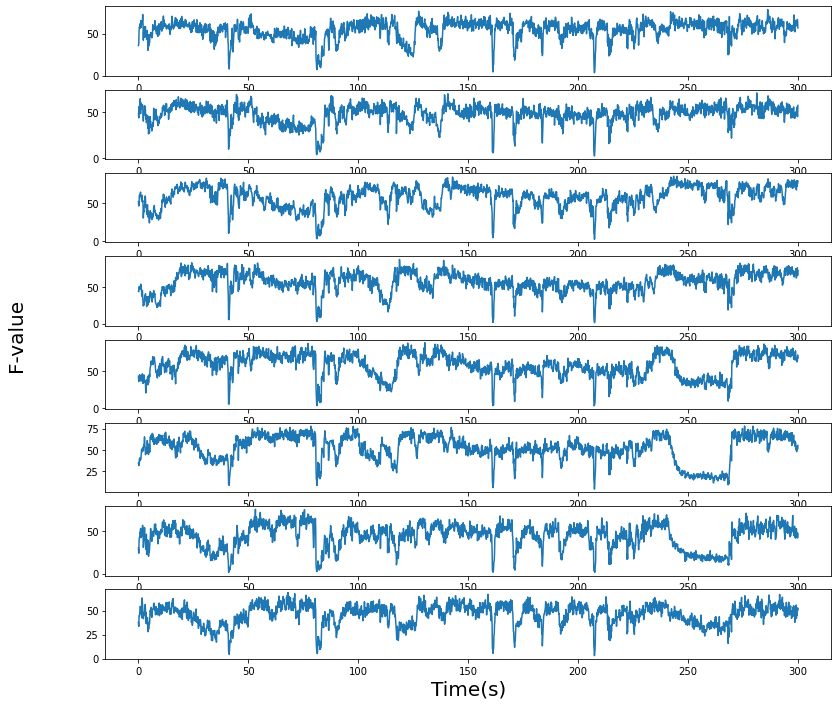

In [28]:
#mode 1 for EPG and PEG
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)

#mode 1 also for PEN2
#for napari ROI, everything same except L9 and R9 corresboding to napari ROP 8,9
F_8_roi = combine_PB_corresponding_ROI(dff_array_input = F_array, napari_ROI = napari_roi , ROI_num = 8, mode = 2, time_array_imaging = time_array_imaging)
ROI_number_combined = 8
fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(time_array_imaging,F_8_roi[:,i])
fig.supylabel('F-value',fontsize=20)
plt.xlabel('Time(s)', fontsize=20)
plt.show()

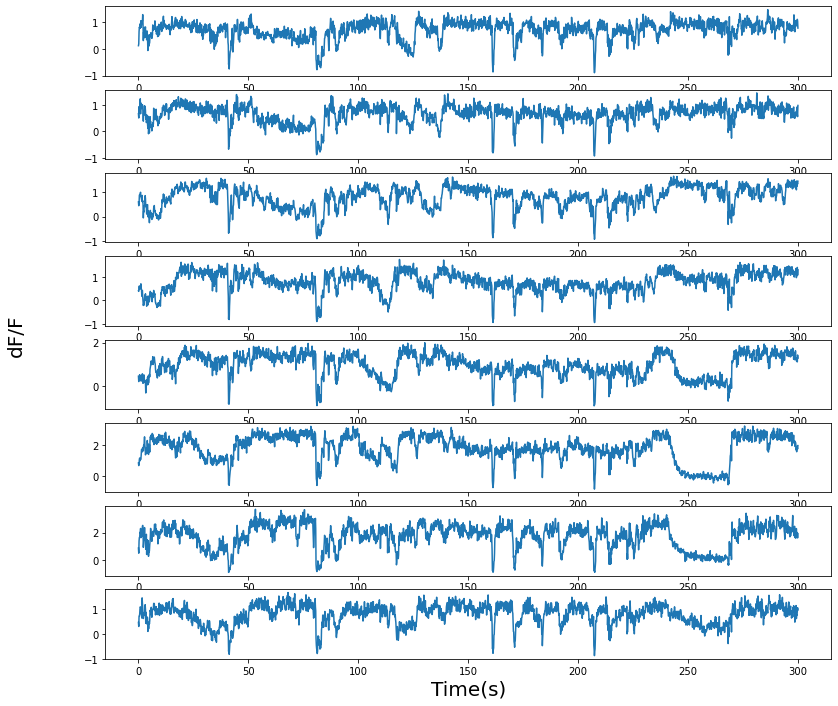

In [29]:
#mode 1 for EPG and PEG
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)


dF_F_array_8_roi = combine_PB_corresponding_ROI(dff_array_input = dF_F_array, napari_ROI = napari_roi , ROI_num = 8, mode = 2, time_array_imaging = time_array_imaging)
ROI_number_combined = 8
fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(time_array_imaging, dF_F_array_8_roi[:,i])
fig.supylabel('dF/F',fontsize=20)
plt.xlabel('Time(s)', fontsize=20)
plt.show()

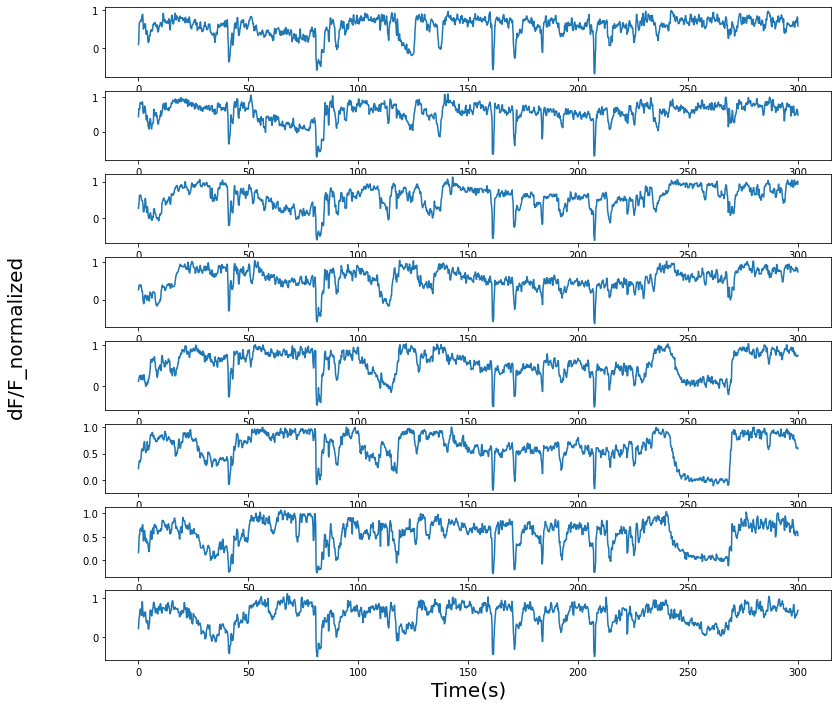

In [30]:
#mode 1 for EPG and PEG
#Rule of combination: L1+R1 (Label in napari 8,9), L8+R2(1,10), L7+R3 (2,11), L6+R4(3,12), L5+R5(4,13), L4+R6(5,14)
#L3+R7(6,15), L2+R8(7,16)


dF_F_array_8_roi_normalized = combine_PB_corresponding_ROI(dff_array_input = dF_F_array_normalized, napari_ROI = napari_roi , ROI_num = 8, mode = 2, time_array_imaging = time_array_imaging)
ROI_number_combined = 8
fig, axs = plt.subplots(ROI_number_combined, 1, figsize=(13, 12))
for i in range(ROI_number_combined):
    ax = axs[i]
    ax.plot(time_array_imaging, dF_F_array_8_roi_normalized[:,i])
fig.supylabel('dF/F_normalized',fontsize=20)
plt.xlabel('Time(s)', fontsize=20)
plt.show()

In [31]:
PVA_radian_array, PVA_strength = PVA_radian_calcul(dF_F_array_8_roi, stack4dMC['volumes [s]'].size,ROI_number_combined )
PVA_radian_array_normalized, PVA_strength_normalized = PVA_radian_calcul(dF_F_array_8_roi_normalized, stack4dMC['volumes [s]'].size,ROI_number_combined)

In [32]:
PVA_angle_Array = PVA_radian_to_angle(PVA_radian_array)
PVA_angle_Array_normalized = PVA_radian_to_angle(PVA_radian_array_normalized)

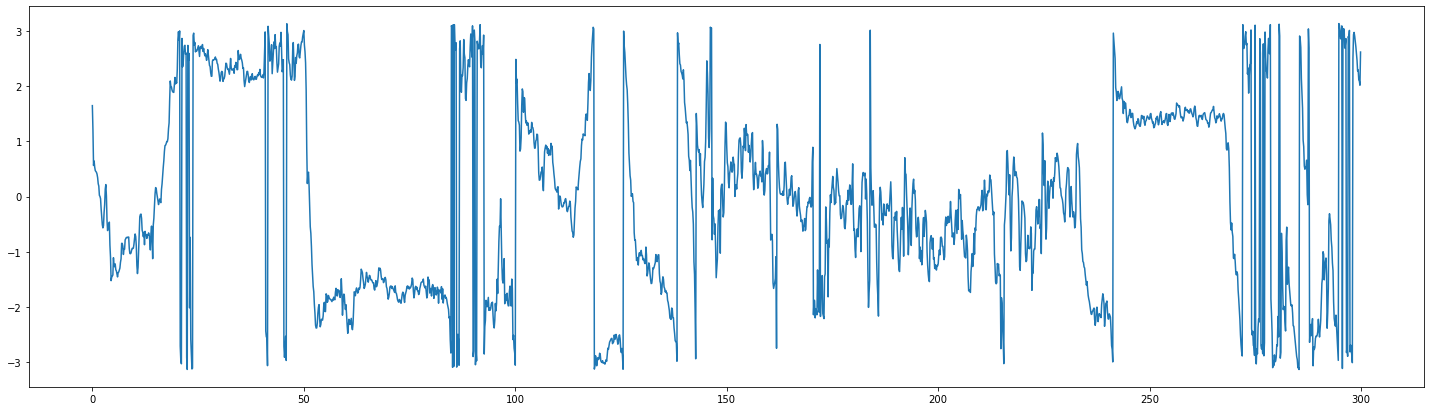

In [33]:
PVA_radian_array_new_normalized = PVA_angle_to_radian(PVA_angle_Array_normalized)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,PVA_radian_array_new_normalized)

In [34]:
PVA_ROI_assigned = PVAangleToRoi(PVA_angle_Array)
PVA_ROI_assigned_normalized = PVAangleToRoi(PVA_angle_Array_normalized)

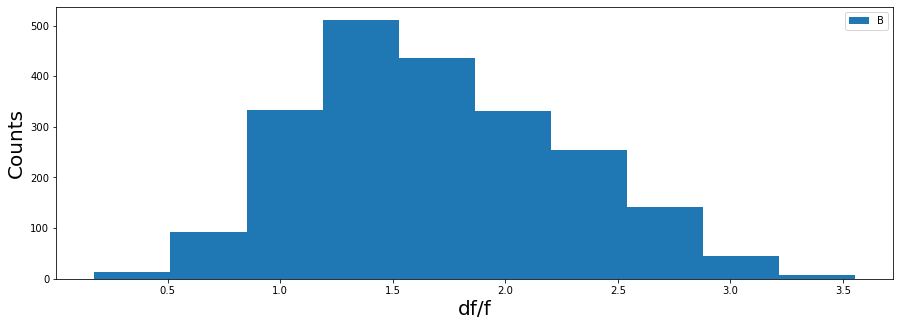

In [35]:
bump_amplitude_dff = calcualteBumpAmplitude(dF_F_array_8_roi)
plt.figure(figsize=(15,5))
plt.hist(bump_amplitude_dff)
plt.legend('Both Bridges')

plt.ylabel('Counts',fontsize=20)
plt.xlabel('df/f', fontsize=20)
plt.show()

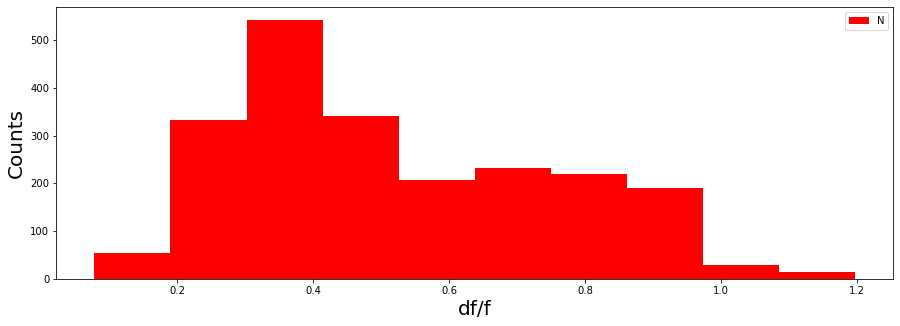

In [36]:
bump_amplitude_dff_normalized = calcualteBumpAmplitude(dF_F_array_8_roi_normalized)
plt.figure(figsize=(15,5))
plt.hist(bump_amplitude_dff_normalized, color ='r')
plt.legend('Normalized')

plt.ylabel('Counts',fontsize=20)
plt.xlabel('df/f', fontsize=20)
plt.show()

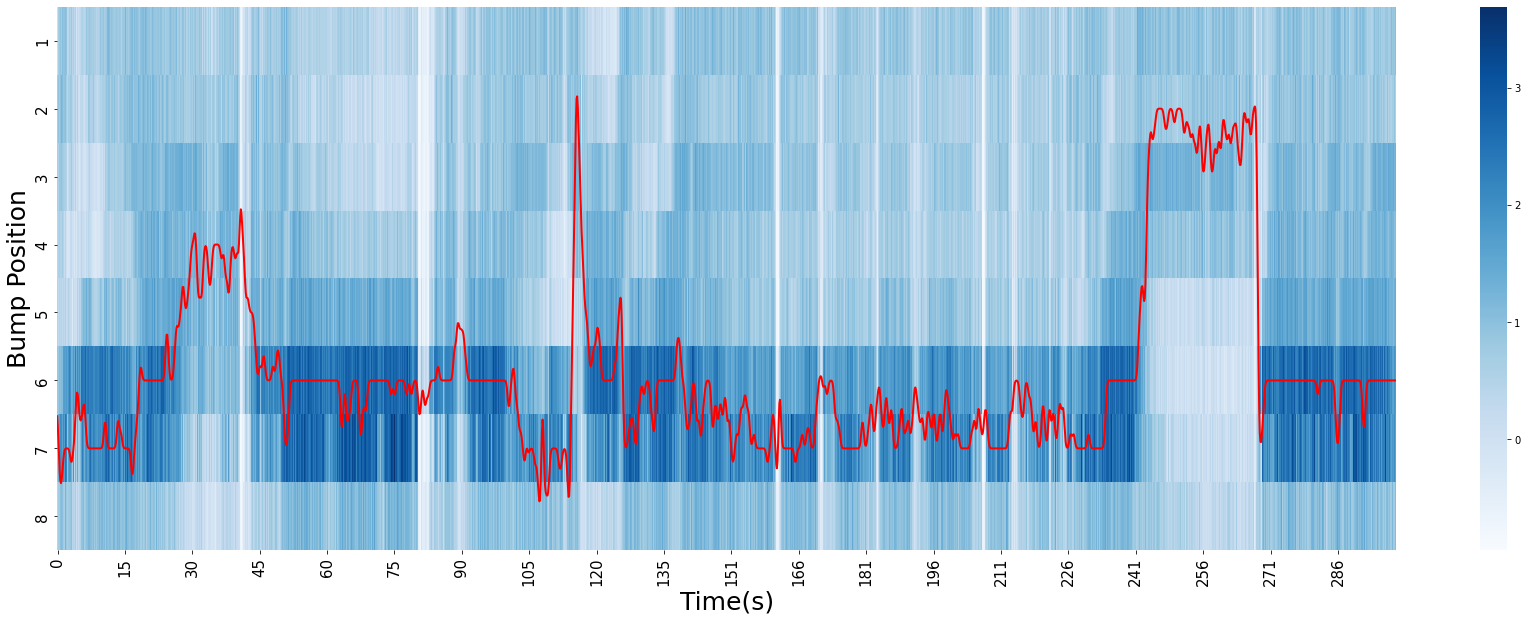

In [37]:
#Plot heatmap of signals in combined ROI and superimpose with PVA
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
df_dff_in_ROI = pd.DataFrame(dF_F_array_8_roi.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(df_dff_in_ROI , cmap='Blues', xticklabels = time_array_imaging_round)
sns.color_palette("light:b", as_cmap=True)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =15)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=15)
plt.locator_params(axis ='x',nbins = 20)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
#plt.plot(PVA_ROI_assigned+0.5,color='red', linewidth =2)
sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned, sigma = 2)+0.5, color='red', linewidth =2)
#sns.lineplot(data = PVA_ROI_assigned+0.5, color='red', linewidth =2)
plt.xlabel('Time(s)', fontsize=25)
plt.ylabel('Bump Position', fontsize=25)
plt.show()

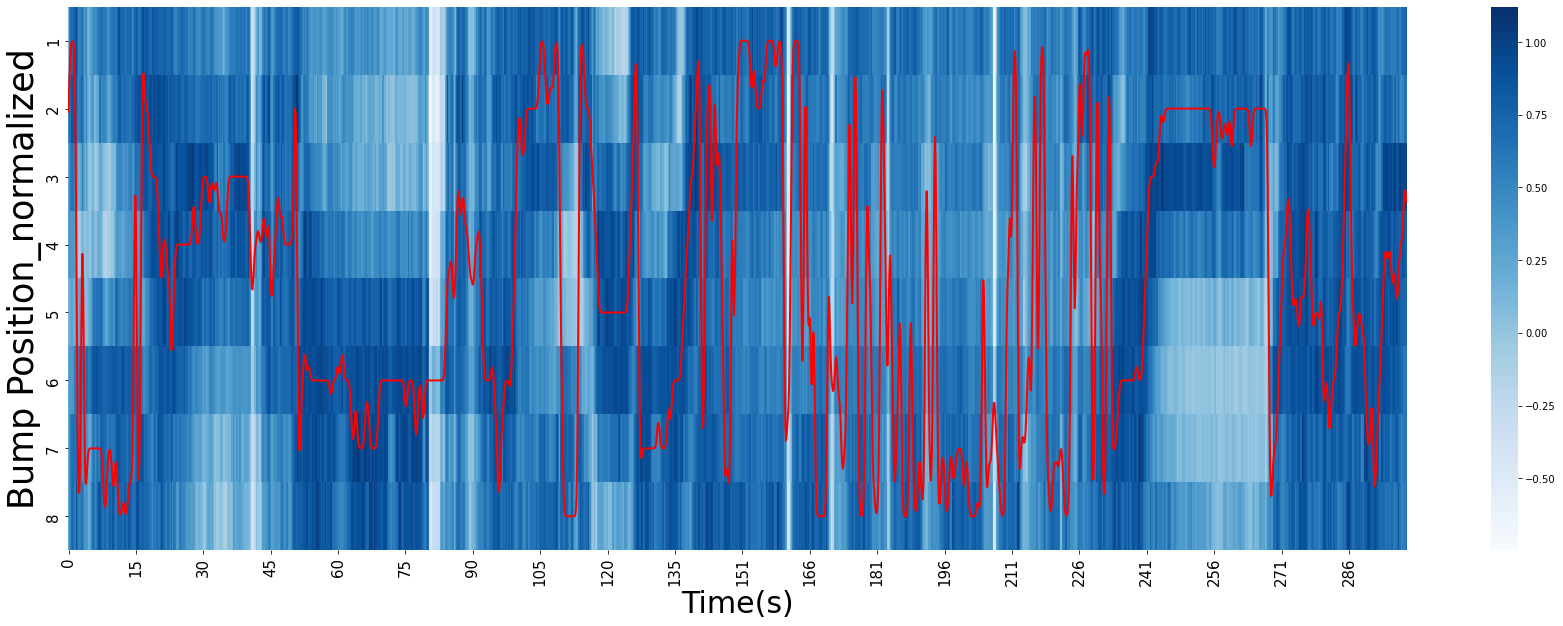

In [38]:
#Plot heatmap of signals in combined ROI and superimpose with PVA
from scipy.ndimage.filters import gaussian_filter1d
plt.figure(figsize= (30,10))
df_dff_in_ROI_normalized = pd.DataFrame(dF_F_array_8_roi_normalized.transpose())
time_array_imaging_round = np.round_(time_array_imaging, decimals =0)
p1 = sns.heatmap(df_dff_in_ROI_normalized , cmap='Blues', xticklabels = time_array_imaging_round)
sns.color_palette("light:b", as_cmap=True)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =15)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=15)
plt.locator_params(axis ='x',nbins = 20)
# + 0.5 to put the PVA line in the middle
#p2 = sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned, sigma = 2)+0.5, color='red', linewidth =2)
#p2 = sns.lineplot(data = low_pass_filter_TQ(PVA_ROI_assigned, lowPassCutoff = 0.5, sampleRate = volume_rate )+0.5, color='red', linewidth =2)
#plt.plot(PVA_ROI_assigned+0.5,color='red', linewidth =2)
sns.lineplot(data = gaussian_filter1d(PVA_ROI_assigned_normalized, sigma = 2)+0.5, color='red', linewidth =2)
#sns.lineplot(data = PVA_ROI_assigned+0.5, color='red', linewidth =2)
plt.xlabel('Time(s)', fontsize=30)
plt.ylabel('Bump Position_normalized', fontsize=35)
plt.show()

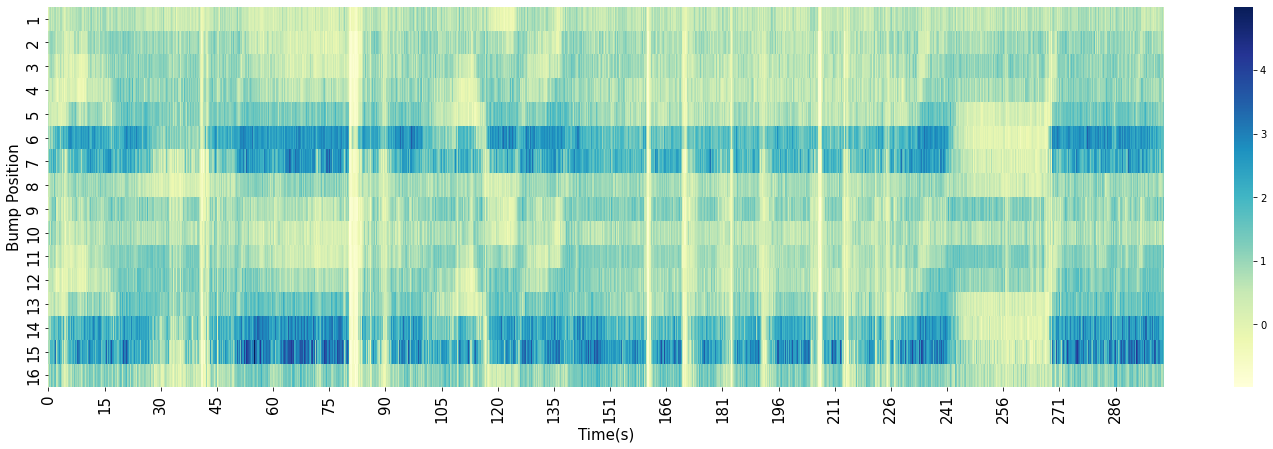

In [39]:
#Plot uncombined 16 ROi all together
plt.figure(figsize= (25,7))
p16 = sns.heatmap(dF_F_array.transpose(),cmap='YlGnBu', xticklabels = time_array_imaging_round)
sns.color_palette("light:b", as_cmap=True)
plt.xticks(ticks=plt.xticks()[0][0:], labels=np.array(plt.xticks()[0][0:]/volume_rate, dtype=np.int64), fontsize =15)
plt.yticks(ticks=plt.yticks()[0][0:], labels=np.array(plt.yticks()[0][0:]+1, dtype=np.int64), fontsize=15)
plt.locator_params(axis ='x',nbins = 20)
plt.xlabel('Time(s)', fontsize=15)
plt.ylabel('Bump Position', fontsize=15)
plt.show()

In [40]:
voltage_recording = pd.read_csv('/home/tianhaoqiu/Desktop/TQfly028-006/TQfly028-006_Cycle00001_VoltageRecording_001.csv')

In [41]:
voltage_recording 

Time(ms)   Start Trigger   Opto Trigger   FicTrac Cam Exp.  \
0              0.00        3.692017       0.016479           3.106689   
1              0.02        4.856262       0.014343           3.106995   
2              0.04        4.977722       0.014343           3.105774   
3              0.06        4.993286       0.012512           3.105774   
4              0.08        4.996033       0.014954           3.107910   
...             ...             ...            ...                ...   
15001096  300021.92        0.021362       0.017395           3.103638   
15001097  300021.94        0.018921       0.014954           3.105774   
15001098  300021.96        0.019226       0.015564           3.105164   
15001099  300021.98        0.020752       0.016785           3.105469   
15001100  300022.00        0.017700       0.014038           3.104248   

           FicTrac Frame Proc.   Heading   Y/Index   Arena DAC1   Arena DAC2  
0                     5.007629  3.035583  0.013428     4.158020     5.083923  
1                     5.001831  3.032532  0.006104     4.159851     5.085144  
2                     0.014343  3.033752  0.006409     4.157104     5.082397  
3                     0.012817  3.031311  0.003662     4.159546     5.085144  
4                     0.014038  3.031921  0.004578     4.160461     5.086060  
...                        ...       ...       ...          ...          ...  
15001096              0.017395  8.481750  0.007019     4.158020     5.083313  
15001097              0.013733  8.480225  0.007324     4.160767     5.086365  
15001098              0.015564  8.481140  0.007935     4.157715     5.082703  
15001099              0.017090  8.481140  0.007935     4.160156     5.085144  
15001100              0.015259  8.480225  0.006714     4.158630     5.083618  

[15001101 rows x 9 columns]

In [42]:
voltage_recording_heading = voltage_recording[' Heading']

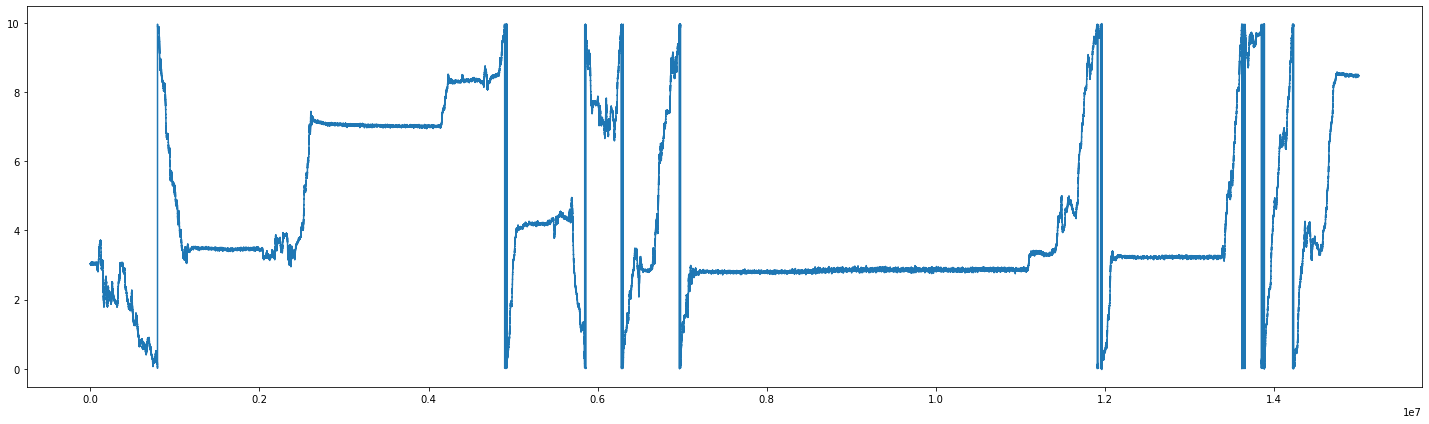

In [43]:
plt.figure(figsize= (25,7))
plt.plot(voltage_recording[' Heading'])

In [44]:
#Input4 = Heading, Input6 =x , Input7 =y

In [45]:
#Read the fictrac raw .dat file and trial start/end info from Bruker
fictrac_data = pd.read_table('/home/tianhaoqiu/Desktop/Fictrac_Recording/TQfly028-03132023/fictrac-20230313_114306.dat', sep =',', header = None, names = ['frame counter', 'delta rotation vector x (cam)', 'delta rotation vector y (cam)','delta rotation vector z (cam)','delta rotation over score', 'delta rotaion vector 1 (lab)','delta rotaion vector 2 (lab)', 'delta rotaion vector 3 (lab)', 'absolute rotation vector 1 (cam)','absolute rotation vector 2 (cam)','absolute rotation vector 3 (cam)','absolute rotation vector 1 (lab)','absolute rotation vector 2 (lab)','absolute rotation vector 3 (lab)','integrated x', 'integrated y','integrated heading','animal movement direcrtion','animal movement speed', 'integrated forward motion','integrated side motion','timestamp','sequence counter','delta timestamp','alt.timestamp'] )
fictrac_data

frame counter  delta rotation vector x (cam)  \
0                    0                       0.000000   
1                    1                       0.000000   
2                    2                       0.000787   
3                    3                      -0.004838   
4                    4                      -0.004495   
...                ...                            ...   
1549962        1550726                       0.007227   
1549963        1550727                      -0.007338   
1549964        1550728                      -0.008518   
1549965        1550729                       0.008196   
1549966        1550730                       0.002094   

         delta rotation vector y (cam)  delta rotation vector z (cam)  \
0                             0.000000                       0.000000   
1                             0.000000                       0.000000   
2                            -0.000077                      -0.006794   
3                             0.000136                       0.001988   
4                             0.000690                      -0.004587   
...                                ...                            ...   
1549962                       0.007760                       0.012817   
1549963                       0.006906                      -0.001525   
1549964                       0.004041                       0.007297   
1549965                       0.003596                      -0.014314   
1549966                      -0.000260                       0.019957   

         delta rotation over score  delta rotaion vector 1 (lab)  \
0                         0.000000                      0.000000   
1                      4220.558099                      0.000000   
2                      4042.203846                     -0.005587   
3                      4136.040241                     -0.000567   
4                      4184.840611                     -0.006199   
...                            ...                           ...   
1549962                2526.257042                      0.014373   
1549963                2137.287986                     -0.005128   
1549964                2166.681338                      0.002176   
1549965                2161.123239                     -0.008811   
1549966                1937.404930                      0.018531   

         delta rotaion vector 2 (lab)  delta rotaion vector 3 (lab)  \
0                            0.000000                      0.000000   
1                            0.000000                      0.000000   
2                            0.003932                     -0.000337   
3                           -0.005199                      0.000145   
4                           -0.001758                      0.000441   
...                               ...                           ...   
1549962                      0.000287                      0.008370   
1549963                     -0.005678                      0.006733   
1549964                     -0.010941                      0.004206   
1549965                      0.014054                      0.003140   
1549966                     -0.007681                      0.000568   

         absolute rotation vector 1 (cam)  absolute rotation vector 2 (cam)  \
0                                0.000000                          0.000000   
1                                0.000000                          0.000000   
2                                0.000787                         -0.000077   
3                               -0.004051                          0.000043   
4                               -0.008547                          0.000732   
...                                   ...                               ...   
1549962                         -1.107877                         -2.021505   
1549963                         -1.109299                         -2.013362   
1549964                         -1.104914                         

In [46]:
with open('/home/tianhaoqiu/Desktop/Fictrac_Recording/TQfly028-03132023/TQfly028_scan5.pkl', 'rb') as f:
    fictracinfo = pickle.load(f)
fictracinfo

{'start': [1419927],
 'opto': [],
 'abort': [1520520],
 'start_trig_falling_edge': [1419930]}

In [47]:
start_frame_index = fictracinfo['start_trig_falling_edge'][0] - 1
abort_frame_index = fictracinfo['abort'][0]

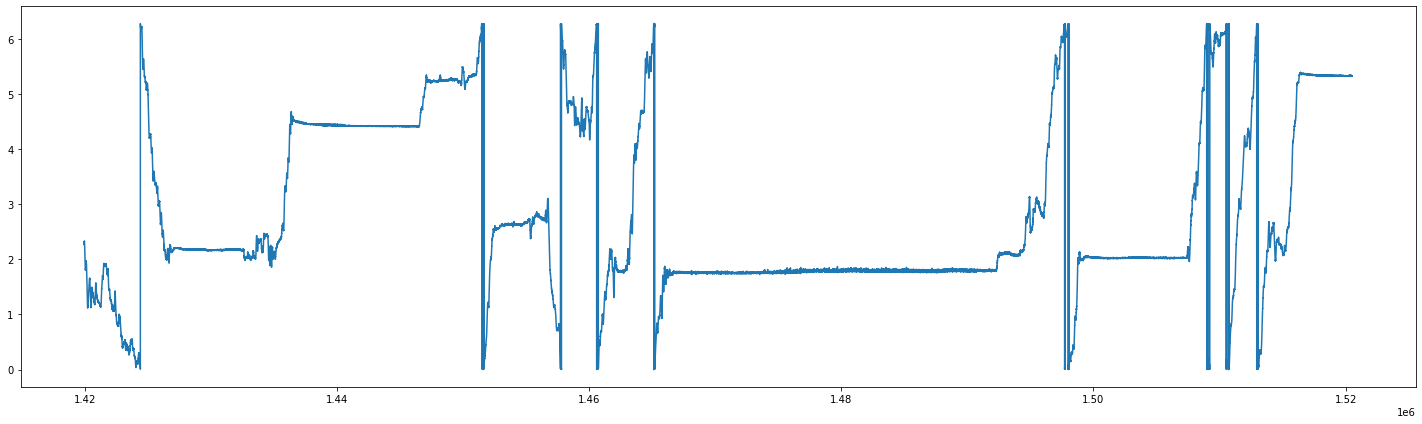

In [48]:
# the scanning start actually one frame before the falling_edge
fictrac_heading = fictrac_data['integrated heading']
fictrac_integrated_x = fictrac_data['integrated x']
fictrac_integrated_y = fictrac_data['integrated y']
plt.figure(figsize= (25,7))
plt.plot(fictrac_heading[start_frame_index:abort_frame_index ])

In [49]:
#change it to binary
fictrac_frame_proc = voltage_recording[' FicTrac Frame Proc.']
pinn_signal = np.zeros(len(fictrac_frame_proc))
for i in range(len(fictrac_frame_proc)):
    if fictrac_frame_proc[i] < 1:
        pinn_signal[i] = 0
    else:
        pinn_signal[i] = 1


(98927,)

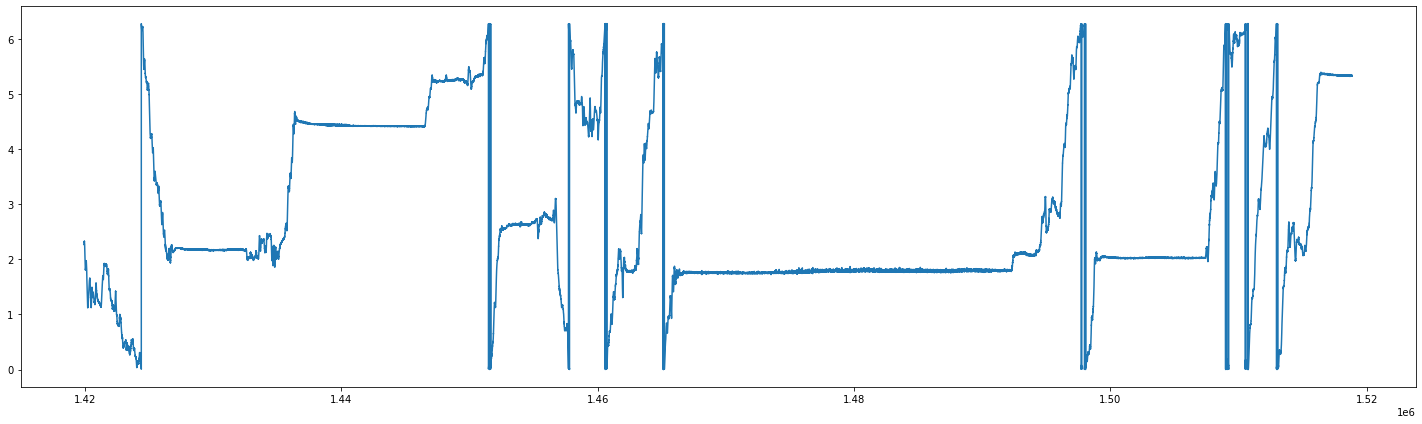

In [50]:
#find every time pinn value is up to 1(locked to each scanning frame)
up_index = np.argwhere(np.diff(pinn_signal)==1)
plt.figure(figsize= (25,7))
plt.plot(fictrac_heading[start_frame_index:start_frame_index+len(up_index)])
fictrac_heading[start_frame_index:start_frame_index+len(up_index)].shape

In [51]:
behavior_sampling_rate =int(np.ceil(len(up_index)/(volume_cycle*volume_time)))

Text(0, 0.5, 'Voltage')

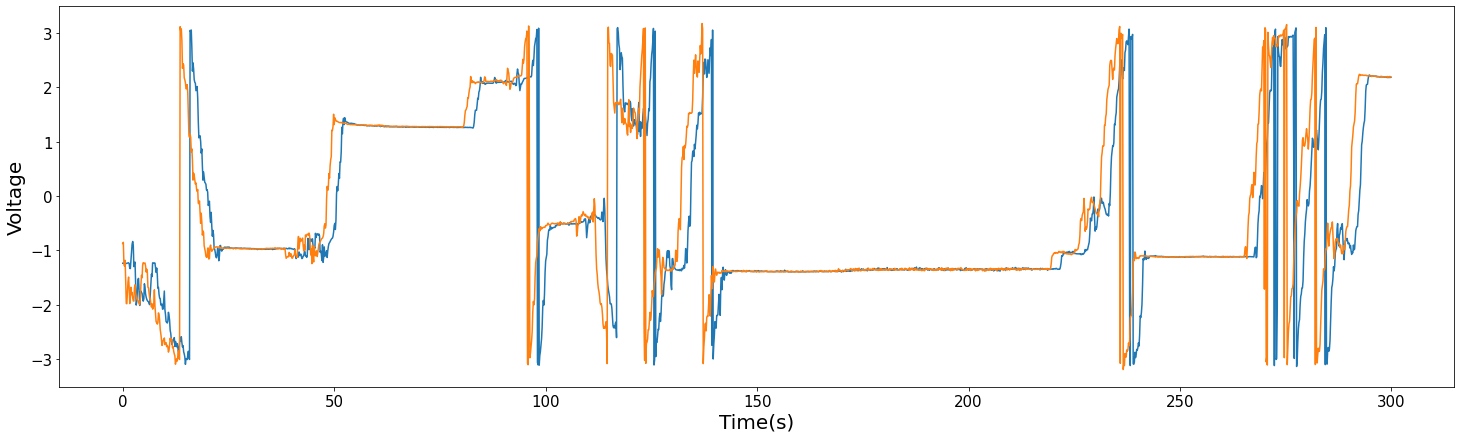

In [52]:
heading_array = voltage_recording [' Heading']
time_array_initial_fictrac = np.arange(len(heading_array))/fictrack_sampling_rate
head_array_filtered = low_pass_filter_TQ(heading_array, 100 ,fictrack_sampling_rate)
head_array_filtered = low_pass_filter_TQ(head_array_filtered, 100 ,fictrack_sampling_rate)
head_array_downsampled = downsample_heading_to_total_volume(volume_cycle, head_array_filtered)

test = fictrac_heading[start_frame_index:start_frame_index+len(up_index)]
test_filtered = low_pass_filter_TQ(test, 100 ,behavior_sampling_rate)
test_filtered = low_pass_filter_TQ(test_filtered, 100 ,behavior_sampling_rate)
test_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, test_filtered)

plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,head_array_downsampled*np.pi*2/10-np.pi)
plt.plot(time_array_imaging,test_filtered_downsampled-np.pi)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Voltage', fontsize=20)

In [53]:
import statsmodels.api as sm
correlate_array_fictrac_voltageRecording= np.zeros(5000)
for i in range(len(correlate_array_fictrac_voltageRecording)):
    test_fictrac_behavior = fictrac_heading[start_frame_index-i:start_frame_index-i+len(up_index)]
    test_fictrac_behavior = low_pass_filter_TQ(test_fictrac_behavior, 100 ,behavior_sampling_rate)
    test_fictrac_behavior= low_pass_filter_TQ(test_fictrac_behavior, 100 ,behavior_sampling_rate)
    test_fictrac_behavior = downsample_heading_to_total_volume(volume_cycle, test_fictrac_behavior)
    correlate_array_fictrac_voltageRecording[i] = np.correlate(test_fictrac_behavior-np.pi,head_array_downsampled*np.pi*2/10-np.pi)
np.argwhere(correlate_array_fictrac_voltageRecording==np.max(correlate_array_fictrac_voltageRecording))

array([[767]])

In [54]:
corrected_frame =  np.argwhere(correlate_array_fictrac_voltageRecording==np.max(correlate_array_fictrac_voltageRecording))[0][0]
start_frame_index_corrected = start_frame_index - corrected_frame

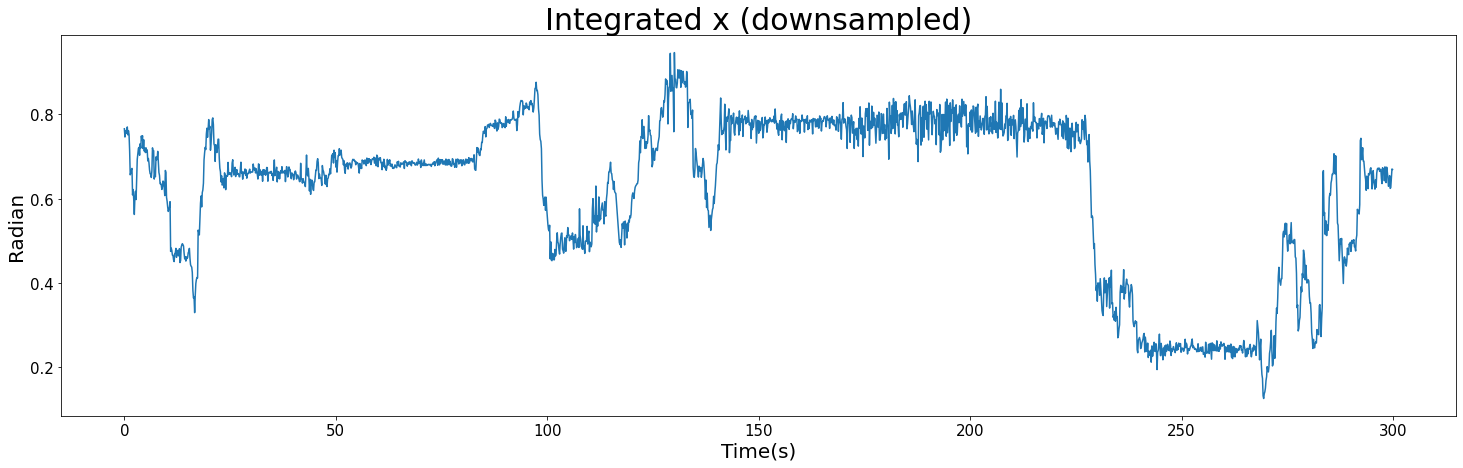

In [55]:
fictrac_integrated_x_filtered = low_pass_filter_TQ(fictrac_integrated_x[start_frame_index_corrected :start_frame_index_corrected +len(up_index)],100,behavior_sampling_rate)
fictrac_integrated_x_filtered = low_pass_filter_TQ(fictrac_integrated_x_filtered ,100,behavior_sampling_rate)
fictrac_integrated_x_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, fictrac_integrated_x_filtered)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,fictrac_integrated_x_filtered_downsampled)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.title('Integrated x (downsampled)', fontsize =30)
plt.show()

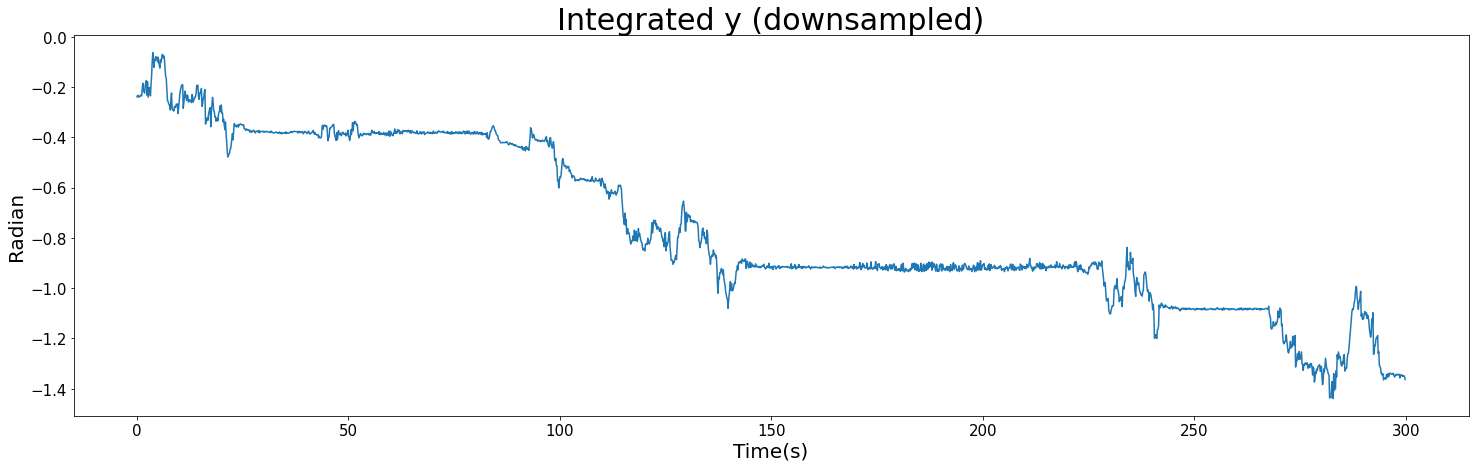

In [56]:
fictrac_integrated_y_filtered = low_pass_filter_TQ(fictrac_integrated_y[start_frame_index_corrected :start_frame_index_corrected +len(up_index)],100,behavior_sampling_rate)
fictrac_integrated_y_filtered = low_pass_filter_TQ(fictrac_integrated_y_filtered ,100,behavior_sampling_rate)
fictrac_integrated_y_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, fictrac_integrated_y_filtered)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,fictrac_integrated_y_filtered_downsampled)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.title('Integrated y (downsampled)', fontsize =30)
plt.show()

In [57]:
fictrac_heading_corrected = fictrac_heading[start_frame_index_corrected :start_frame_index_corrected +len(up_index)]
fictrac_heading_corrected_filtered = low_pass_filter_TQ(fictrac_heading_corrected, 100 ,behavior_sampling_rate)
fictrac_heading_corrected_filtered = low_pass_filter_TQ(fictrac_heading_corrected_filtered, 100 ,behavior_sampling_rate)
fictrac_heading_corrected_filtered_downsampled = downsample_heading_to_total_volume(volume_cycle, fictrac_heading_corrected_filtered)

Text(0, 0.5, 'Voltage')

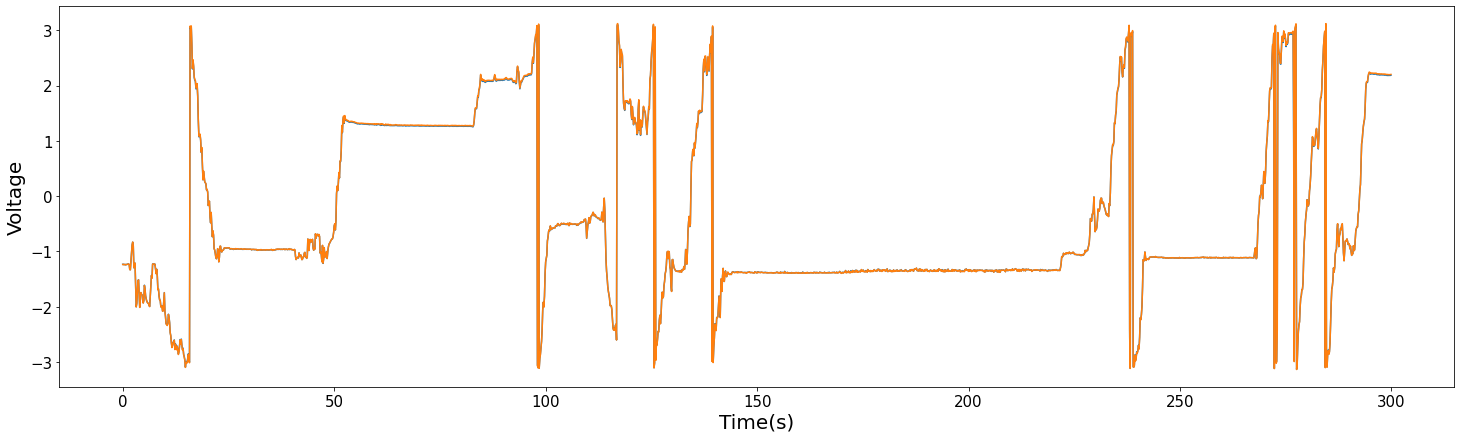

In [58]:
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,head_array_downsampled*np.pi*2/10-np.pi)
plt.plot(time_array_imaging,fictrac_heading_corrected_filtered_downsampled-np.pi)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Voltage', fontsize=20)

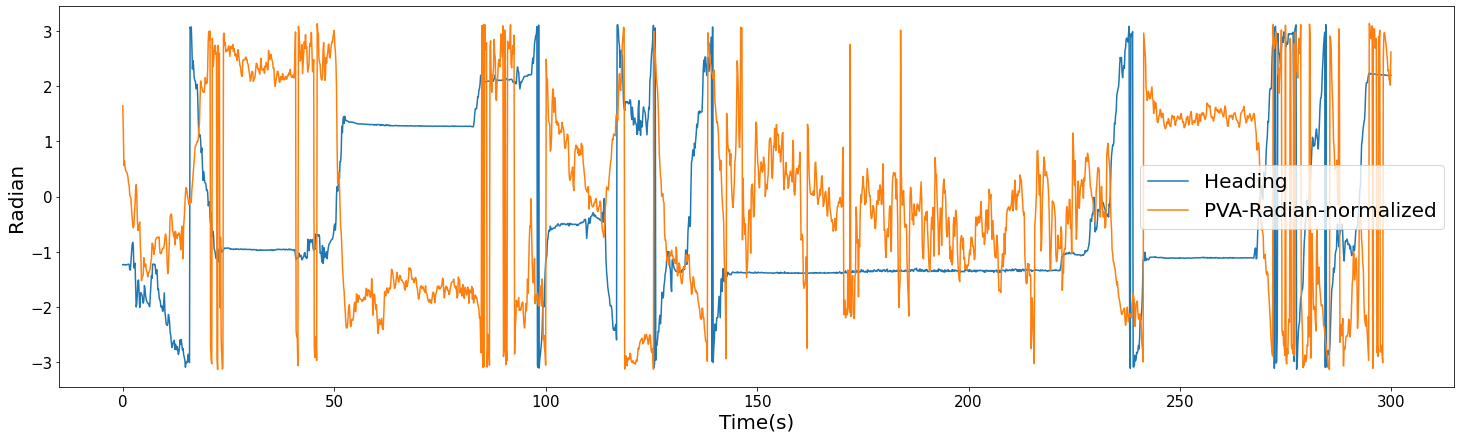

In [59]:
#0-10V equivalent to -pi to pi
#head_array_downsampled_wrapped = head_array_downsampled * np.pi*2/10 - np.pi
head_array_downsampled_wrapped = fictrac_heading_corrected_filtered_downsampled -np.pi
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,head_array_downsampled_wrapped)
plt.plot(time_array_imaging,PVA_radian_array_normalized)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.legend(['Heading','PVA-Radian-normalized'],fontsize=20)

Text(0, 0.5, 'Radian Offset')

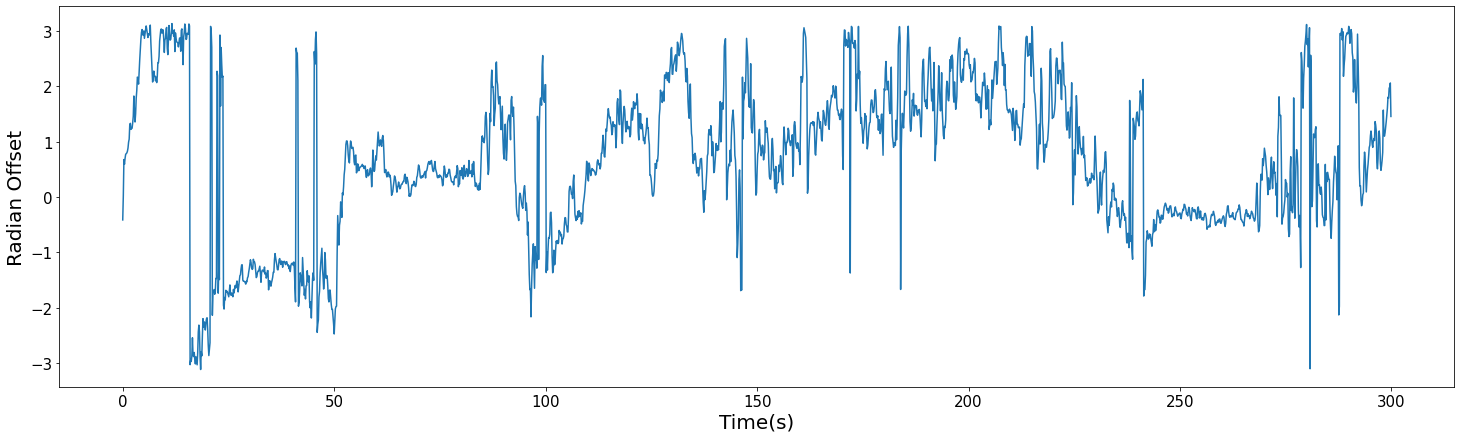

In [60]:
barPosition_array_downsampled_wrapped = -head_array_downsampled_wrapped
radian_offset = offset_calculation(barPosition_array_downsampled_wrapped, PVA_radian_array, IfRadian = True)
radian_offset_normalized = offset_calculation(barPosition_array_downsampled_wrapped, PVA_radian_array_normalized, IfRadian = True)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,radian_offset_normalized)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian Offset', fontsize=20)

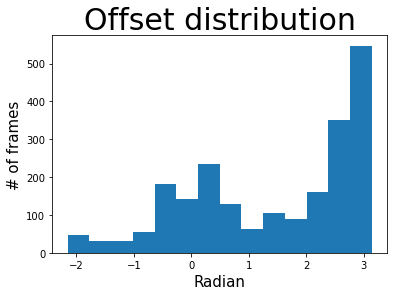

In [61]:
plt.hist(radian_offset,bins='auto')
plt.title('Offset distribution',fontsize=30)
plt.xlabel('Radian',fontsize=15)
plt.ylabel('# of frames',fontsize=15)
plt.show()

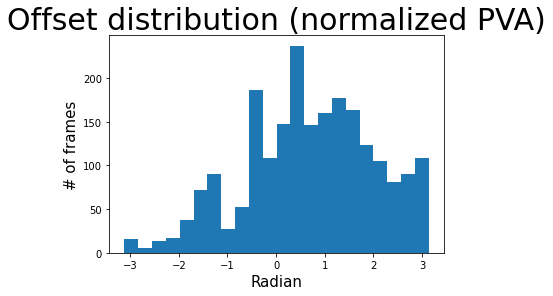

In [62]:
plt.hist(radian_offset_normalized,bins='auto')
plt.title('Offset distribution (normalized PVA)',fontsize=30)
plt.xlabel('Radian',fontsize=15)
plt.ylabel('# of frames',fontsize=15)
plt.show()

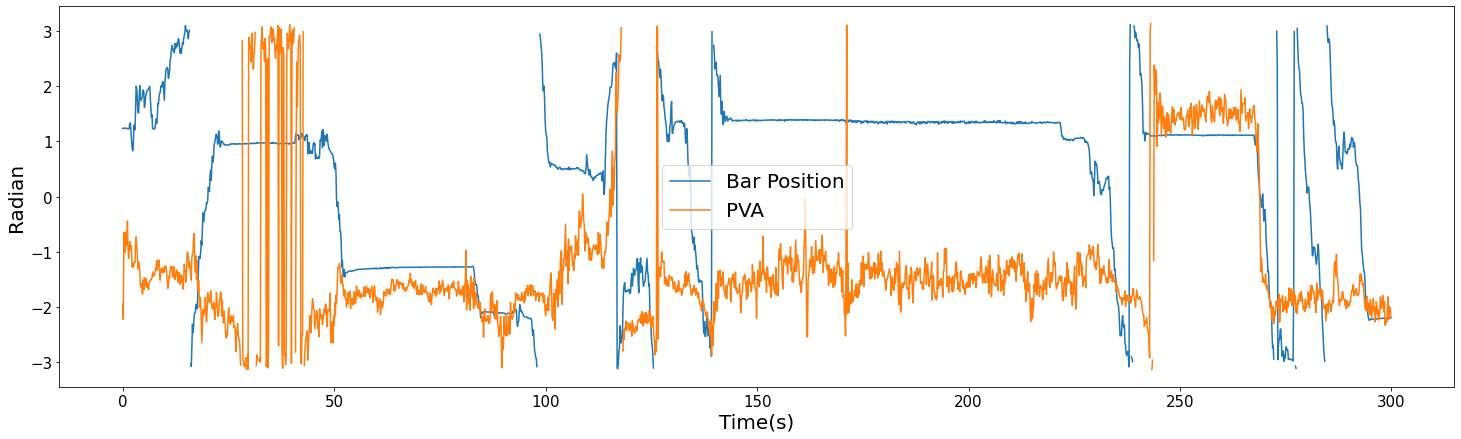

In [63]:
plt.figure(figsize= (25,7))
barPosition_diff = np.diff(barPosition_array_downsampled_wrapped)
barPosition_diff = np.concatenate([[0],barPosition_diff])
PVA_radian_array_diff = np.diff(PVA_radian_array)
PVA_radian_array_diff = np.concatenate([[0],PVA_radian_array_diff])
PVA_radian_array_plot = np.ma.masked_where(np.abs(PVA_radian_array_diff)>=6,PVA_radian_array)
barPosition_array_downsampled_wrapped_plot = np.ma.masked_where(np.abs(barPosition_diff)>=6,barPosition_array_downsampled_wrapped)
plt.plot(time_array_imaging,barPosition_array_downsampled_wrapped_plot)
plt.plot(time_array_imaging,PVA_radian_array_plot)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.legend(['Bar Position','PVA'],fontsize=20)

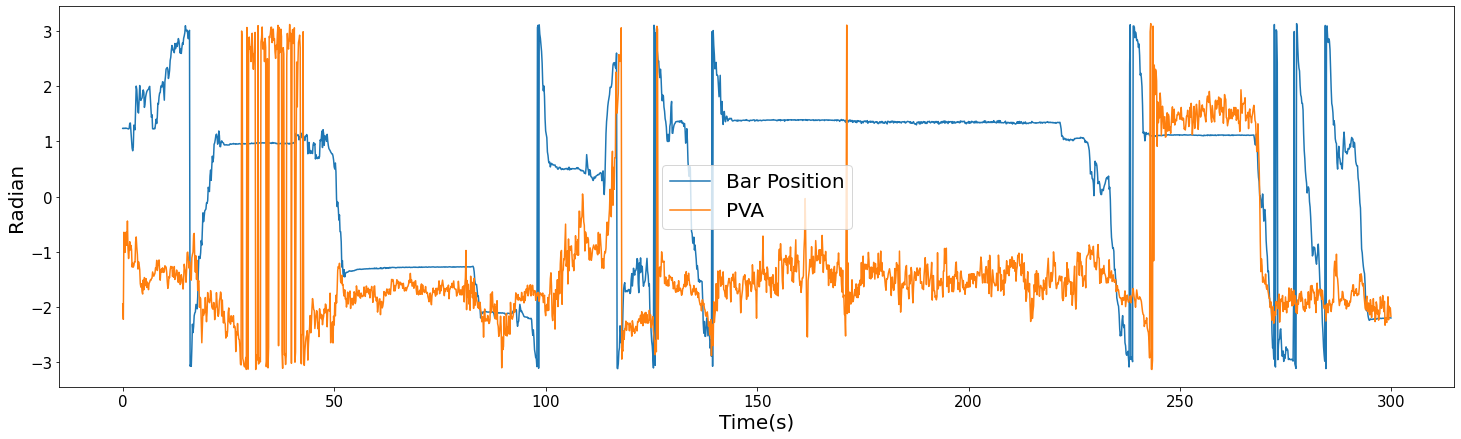

In [64]:
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,barPosition_array_downsampled_wrapped)
plt.plot(time_array_imaging,PVA_radian_array)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.legend(['Bar Position','PVA'],fontsize=20)

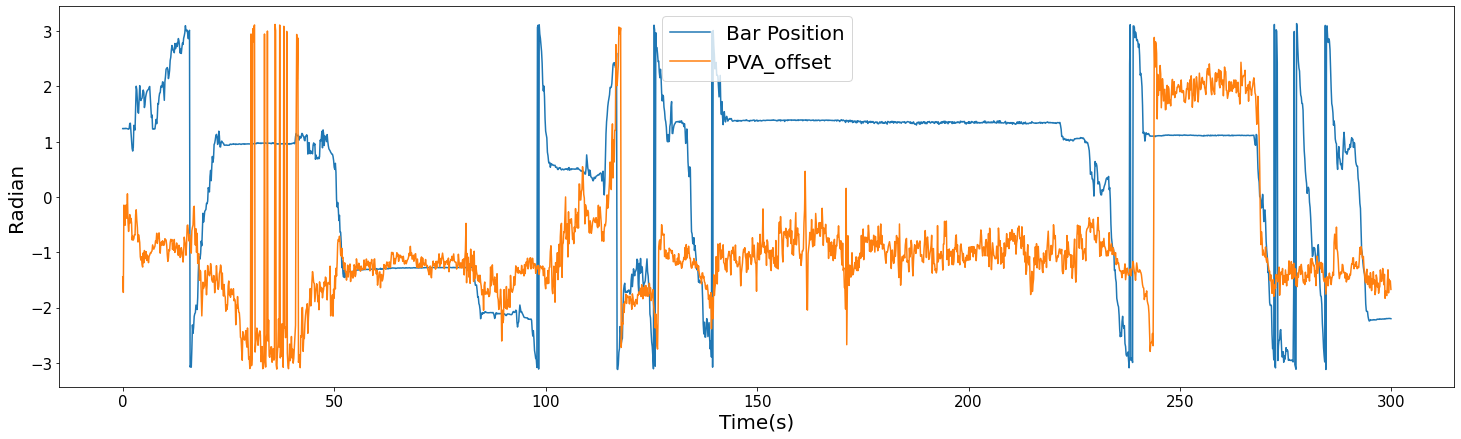

In [65]:
PVA_radian_array_offset =moving_wrapped_plot_by_offset(PVA_radian_array,math.degrees(0.5), ifRadian =True)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,barPosition_array_downsampled_wrapped)
plt.plot(time_array_imaging,PVA_radian_array_offset)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.xlabel('Time(s)', fontsize=20)
plt.ylabel('Radian', fontsize=20)
plt.legend(['Bar Position','PVA_offset'],fontsize=20)

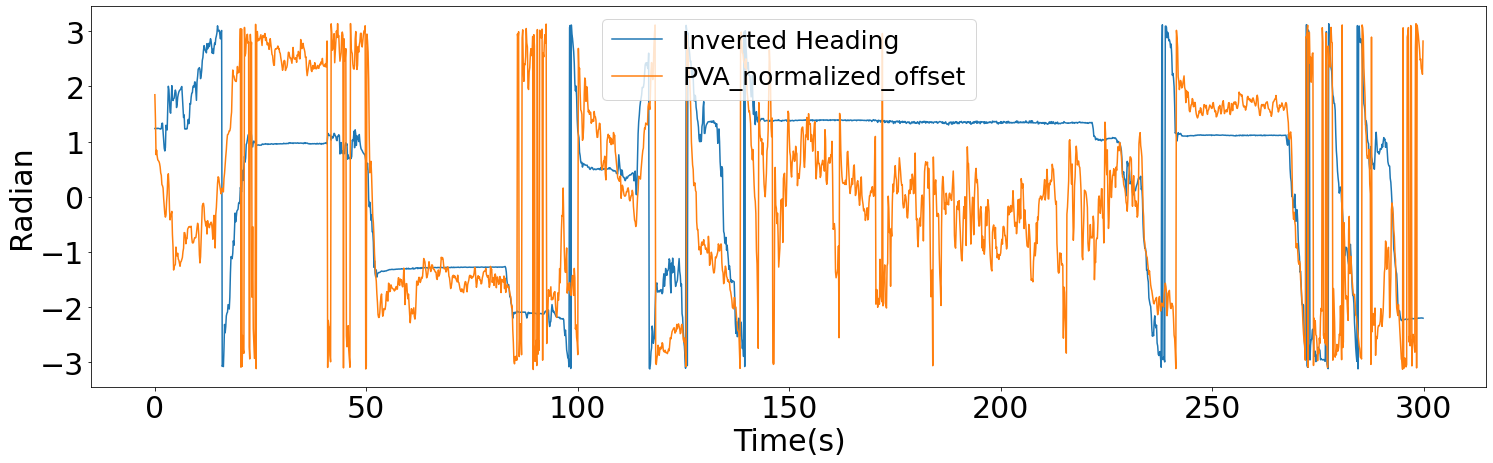

In [66]:
PVA_radian_array_normalized_offset =moving_wrapped_plot_by_offset(PVA_radian_array_normalized,math.degrees(0.2), ifRadian =True)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,barPosition_array_downsampled_wrapped)
plt.plot(time_array_imaging,PVA_radian_array_normalized_offset)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel('Time(s)', fontsize=30)
plt.ylabel('Radian', fontsize=30)
plt.legend(['Inverted Heading','PVA_normalized_offset'],fontsize=25)
#plt.legend(['Bar Position','PVA_normalized_offset'],fontsize=25)
plt.show()

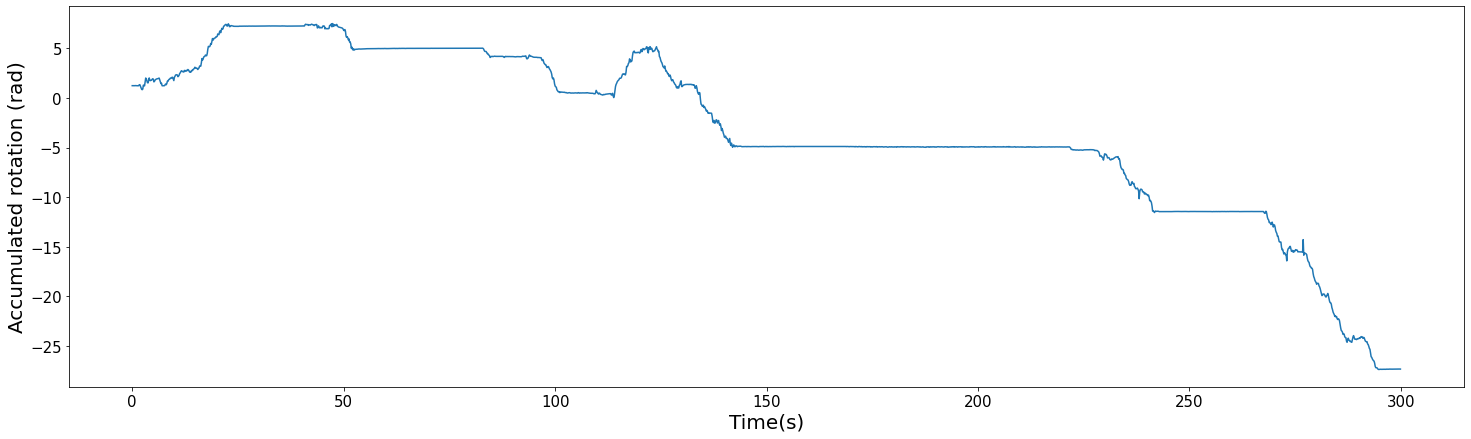

In [67]:
max_Voltage = 10
heading_array_processed = fictrack_signal_decoding(barPosition_array_downsampled_wrapped, time_array_imaging, max_Voltage, already_radian = True)
#heading_array_processed = fictrack_signal_decoding(head_array_downsampled , time_array_imaging, max_Voltage, already_radian = False)

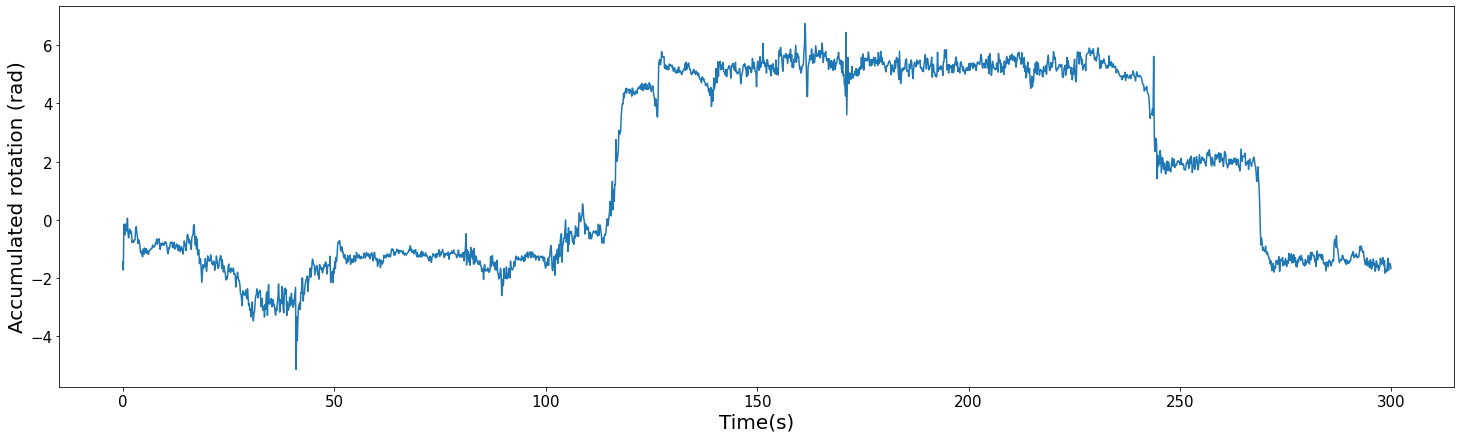

In [68]:
PVA_unwrapped = fictrack_signal_decoding(PVA_radian_array_offset, time_array_imaging, max_voltage = 10, already_radian = True)

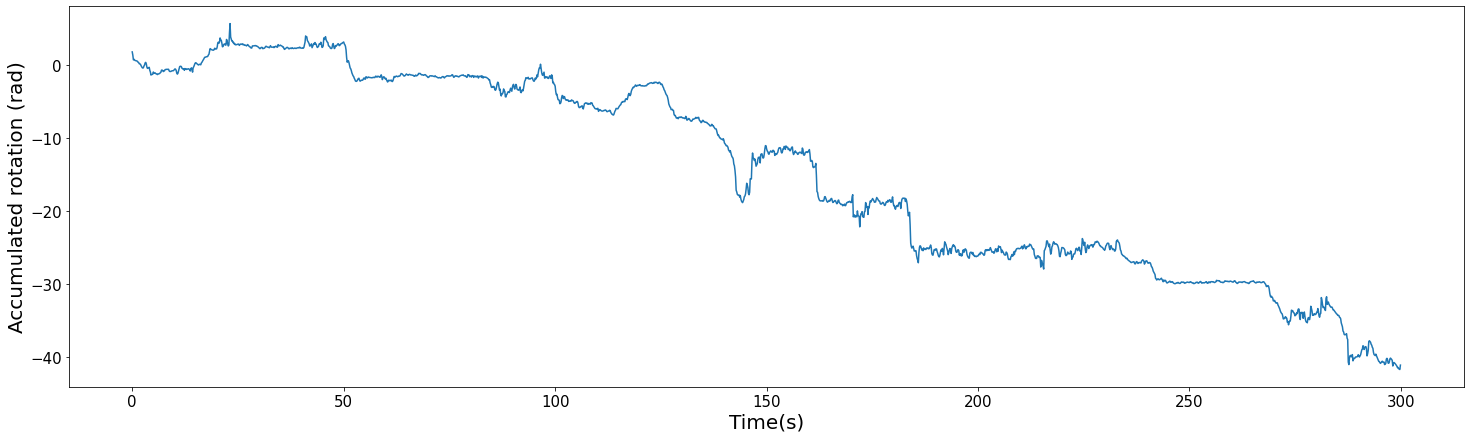

In [69]:
PVA_unwrapped_normalized = fictrack_signal_decoding(PVA_radian_array_normalized_offset, time_array_imaging, max_voltage = 10, already_radian = True)

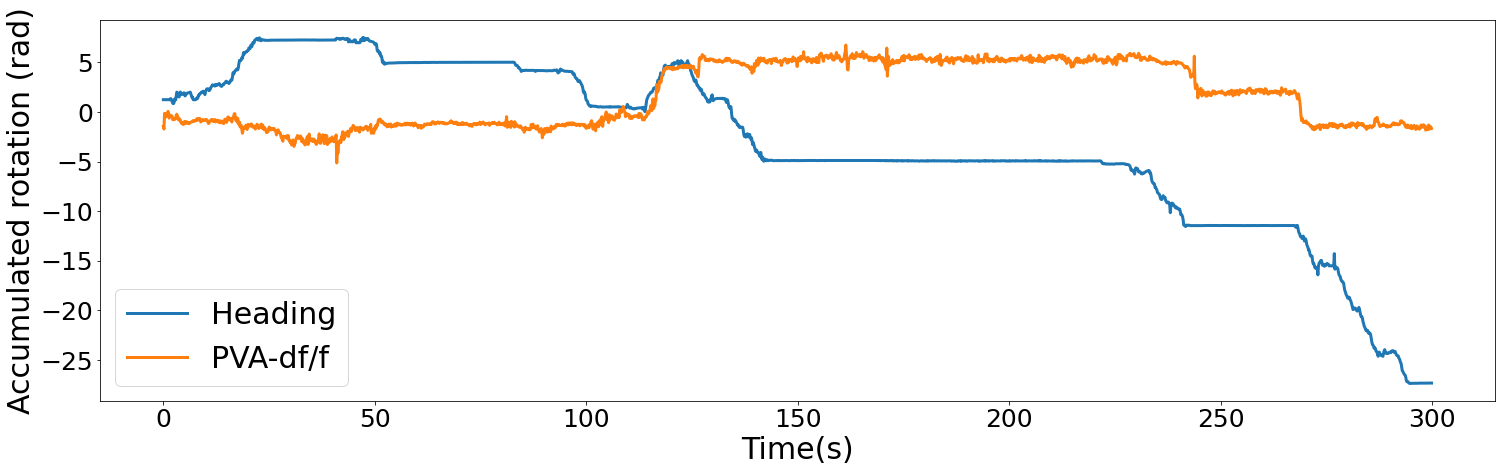

In [70]:
#head_array_downsampled = downsample_heading_to_total_volume(volume_cycle, heading_array_processed)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped,linewidth =3)
plt.xlabel('Time(s)', fontsize=30)
plt.ylabel('Accumulated rotation (rad)', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.legend(['Heading','PVA-df/f'],fontsize=30)
plt.show()

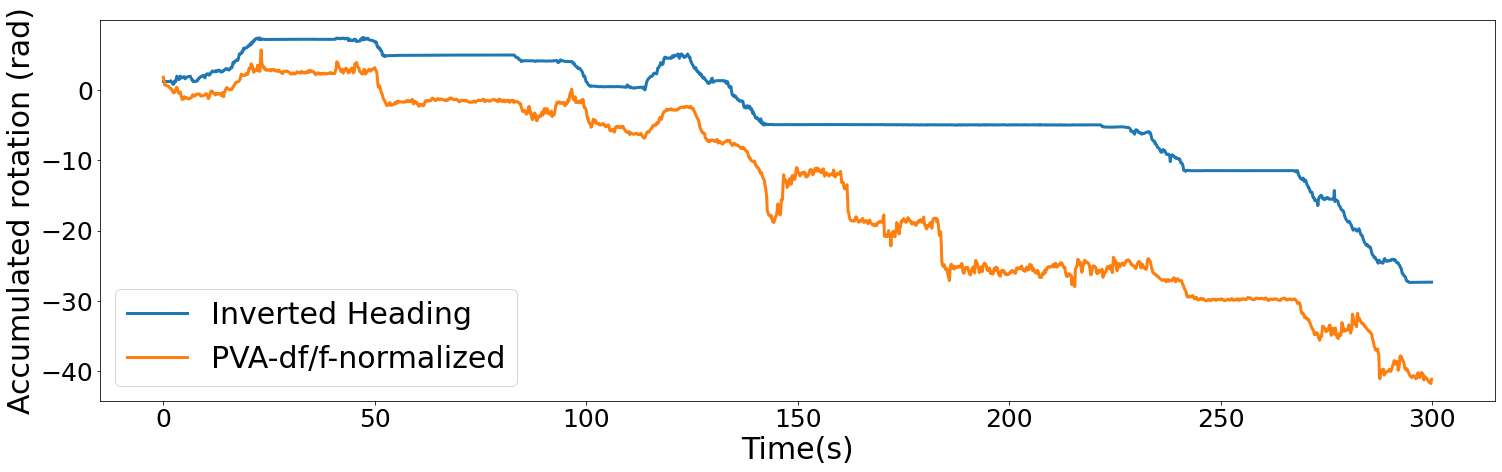

In [71]:
#head_array_downsampled = downsample_heading_to_total_volume(volume_cycle, heading_array_processed)
plt.figure(figsize= (25,7))
plt.plot(time_array_imaging,heading_array_processed,linewidth =3)
plt.plot(time_array_imaging, PVA_unwrapped_normalized,linewidth =3)
plt.xlabel('Time(s)', fontsize=30)
plt.ylabel('Accumulated rotation (rad)', fontsize=30)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
#plt.legend(['Bar Position','PVA-df/f-normalized'],fontsize=30)
plt.legend(['Inverted Heading','PVA-df/f-normalized'],fontsize=30)
plt.show()

In [72]:
#Create a dataframe to contain all different ways calculating unwrapped PVA and/or amplitudes
all_pva_data = pd.DataFrame()
all_pva_data['Heading'] = heading_array_processed 
all_pva_data['PVA_radian_dff'] = PVA_unwrapped 
all_pva_data['PVA_radian_dff_normalized'] = PVA_unwrapped_normalized
#all_pva_data['PVA_radian_dff_sgfiltered'] = PVA_unwrapped_sgfiltered
#all_pva_data['PVA_radian_dff_left_only'] = PVA_unwrapped_dff_left_only
#all_pva_data['PVA_radian_dff_right_only'] =  PVA_unwrapped_dff_right_only
#all_pva_data['PVA_radian_z'] = PVA_unwrapped_z
#all_pva_data['PVA_radian_z_left_only'] = PVA_unwrapped_z_left_only 
#all_pva_data['PVA_radian_z_right_only'] = PVA_unwrapped_z_right_only 
all_pva_data['Bump_amplitude'] = bump_amplitude_dff
#all_pva_data['Bump_amplitude_left_only'] = bump_amplitude_dff_left_only
#all_pva_data['Bump_amplitude_right_only'] = bump_amplitude_dff_right_only
all_pva_data['Heading_velocity'] = np.gradient(heading_array_processed)/volume_time
all_pva_data['PVA_dff_velocity'] = np.gradient(all_pva_data['PVA_radian_dff'])/volume_time
#all_pva_data['PVA_dff_velocity_sgfiltered'] = np.gradient(all_pva_data['PVA_radian_dff_sgfiltered'])/volume_time
#all_pva_data['PVA_dff_left_only_velocity'] = np.gradient(all_pva_data['PVA_radian_dff_left_only'])/volume_time
#all_pva_data['PVA_dff_right_only_velocity'] = np.gradient(all_pva_data['PVA_radian_dff_right_only'])/volume_time
#all_pva_data['PVA_z_velocity'] = np.gradient(all_pva_data['PVA_radian_z'])
#all_pva_data['PVA_z_left_only_velocity'] = np.gradient(all_pva_data['PVA_radian_z_left_only'])
#all_pva_data['PVA_z_right_only_velocity'] = np.gradient(all_pva_data['PVA_radian_z_right_only'])
all_pva_data

Heading  PVA_radian_dff  PVA_radian_dff_normalized  Bump_amplitude  \
0      1.236997       -1.445615                   1.850479        0.749111   
1      1.234388       -1.726222                   1.409820        0.501981   
2      1.242374       -0.146757                   0.764244        1.063502   
3      1.238436       -0.480911                   0.844879        1.202140   
4      1.234631       -0.511949                   0.733986        1.175564   
...         ...             ...                        ...             ...   
2161 -27.329300       -1.734951                 -41.483380        1.066889   
2162 -27.329647       -1.487786                 -41.664126        1.252760   
2163 -27.330178       -1.545501                 -41.687336        1.258955   
2164 -27.331527       -1.519631                 -41.761308        1.181669   
2165 -27.334315       -1.671761                 -41.158504        1.173263   

      Heading_velocity  PVA_dff_velocity  
0            -0.018834         -2.025898  
1             0.019410          4.688679  
2             0.014611          4.495384  
3            -0.027951         -1.318288  
4             0.017349          1.184456  
...                ...               ...  
2161          0.004884         -0.615006  
2162         -0.003171          0.683886  
2163         -0.006786         -0.114955  
2164         -0.014931         -0.455779  
2165         -0.020129         -1.098329  

[2166 rows x 6 columns]

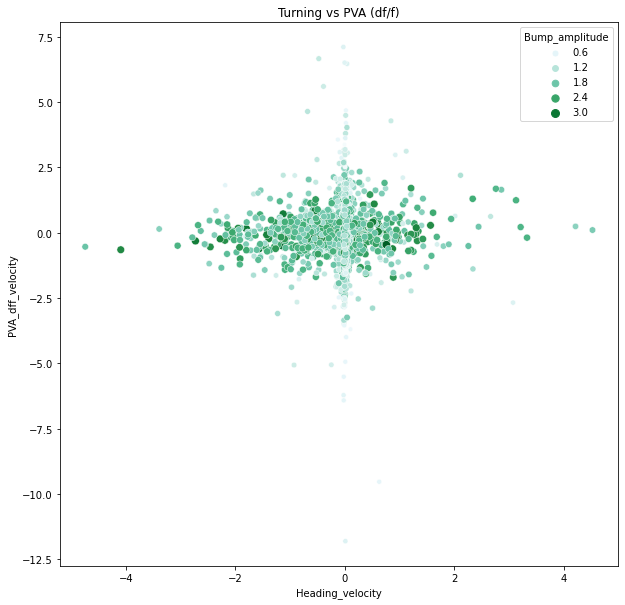

In [73]:
plt.figure(figsize=(10, 10))
plt.title('Turning vs PVA (df/f)')
sns.scatterplot(data = all_pva_data, y = 'PVA_dff_velocity', x = 'Heading_velocity', hue = 'Bump_amplitude', size = 'Bump_amplitude', palette = 'BuGn')
plt.show()


In [74]:
#Calculate velocity and generate correlation matrix of PVA and Heading
def calculate_PVA_heading_velocity_corr(heading_array, PVA_array, volume_time, bump_amplitude):
    heading_velocity = np.gradient(heading_array)/volume_time
    PVA_velocity = np.gradient(PVA_array)/volume_time
    
    abnormal_velocity = np.argwhere(np.absolute(PVA_velocity) > 8.72)
    while (len(abnormal_velocity ) > 0):
        PVA_velocity[abnormal_velocity ] = PVA_velocity[abnormal_velocity -1]
        abnormal_velocity = np.argwhere(np.absolute(PVA_velocity) > 8.72)
    
    abnormal_velocity = np.argwhere(np.absolute(heading_velocity) > 8.72)
    while (len(abnormal_velocity ) > 0):
        heading_velocity[abnormal_velocity ] = heading_velocity[abnormal_velocity -1]
        abnormal_velocity = np.argwhere(np.absolute(heading_velocity) > 8.72)
    
    velocity_corr_array = np.zeros([heading_array.size, 3])
    velocity_corr_array[:,0]=heading_velocity
    velocity_corr_array[:,1]=PVA_velocity
    #gaussian_window = signal.windows.gaussian(5,0.6)
    #velocity_corr_array[:,0]= np.convolve (velocity_corr_array[:,0], gaussian_window, mode = 'same')
    #velocity_corr_array[:,1]= np.convolve (velocity_corr_array[:,1], gaussian_window, mode = 'same')
    velocity_corr_array[:,2]=bump_amplitude
    
    import seaborn as sns
    import pandas as pd
    df = pd.DataFrame(velocity_corr_array, columns = ['Turning Velocity', 'PVA Velocity', 'PVA Amplitude_green'])
    sns.scatterplot(data = df, x='Turning Velocity', y='PVA Velocity')
    plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 10)
    plt.ylabel('PVA Velocity (Rad/Sec)', fontsize = 10)    
    return df['PVA Velocity'], df['Turning Velocity'], df

0.04250527346986709

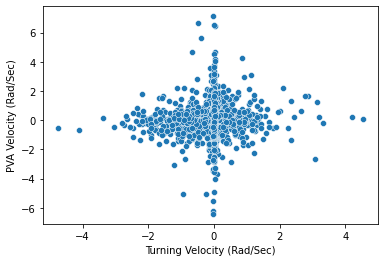

In [75]:
PVA_vel, Heading_vel, velocity_df = calculate_PVA_heading_velocity_corr(heading_array_processed, PVA_unwrapped, volume_time=volume_time, bump_amplitude= bump_amplitude_dff)
np.corrcoef(PVA_vel,Heading_vel)[0,1]

0.07432475755363087

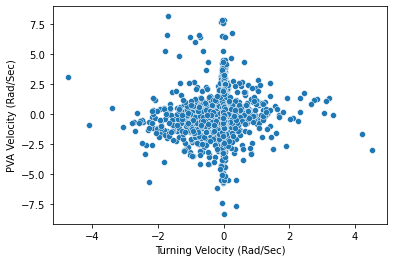

In [76]:
PVA_vel_normalized, Heading_vel, velocity_df = calculate_PVA_heading_velocity_corr(heading_array_processed, PVA_unwrapped_normalized, volume_time=volume_time, bump_amplitude= bump_amplitude_dff_normalized)
np.corrcoef(PVA_vel_normalized,Heading_vel)[0,1]

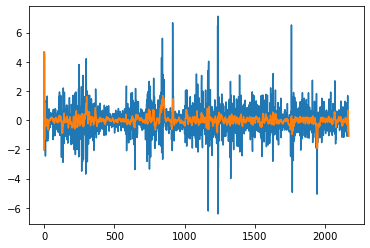

In [77]:
PVA_vel_avt = averaging_frame(PVA_vel, 10)
plt.plot(PVA_vel)
plt.plot(PVA_vel_avt)

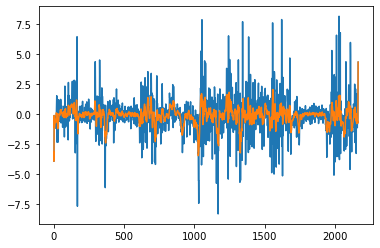

In [78]:
PVA_vel_avt_normalized = averaging_frame(PVA_vel_normalized, 10)
plt.plot(PVA_vel_normalized)
plt.plot(PVA_vel_avt_normalized)

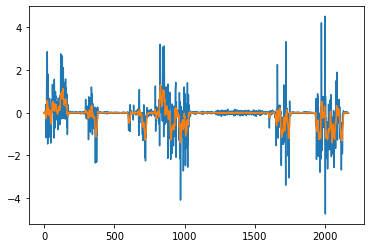

In [79]:
Heading_vel_avt = averaging_frame(Heading_vel, 10)
plt.plot(Heading_vel)
plt.plot(Heading_vel_avt)

0.10473081901667482

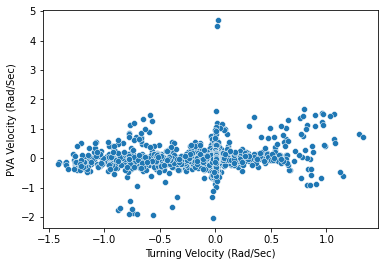

In [80]:
sns.scatterplot(x =Heading_vel_avt, y=PVA_vel_avt)
plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 10)
plt.ylabel('PVA Velocity (Rad/Sec)', fontsize = 10)  
np.corrcoef(PVA_vel_avt,Heading_vel)[0,1]

0.24051189326219333

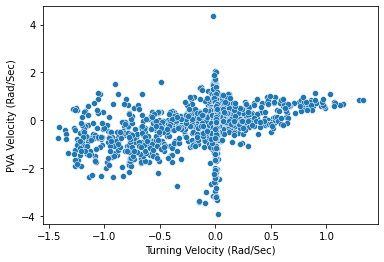

In [81]:
sns.scatterplot(x =Heading_vel_avt, y=PVA_vel_avt_normalized)
plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 10)
plt.ylabel('PVA Velocity (Rad/Sec)', fontsize = 10)  
np.corrcoef(PVA_vel_avt_normalized,Heading_vel)[0,1]

In [82]:
#Maximum velocity 500 degree/s in radians
turningVel_threshold_up = 8.72
pvaVel_threshold_up = 8.72
#About 12 degrees/s in radians transformed from green 1mm/s on 6.35mm diameter ball
turningVel_threshold_down = 0.21
pvaVel_threshold_down = 0.21
amplitude_threshold = 0.8

In [83]:
cross_correlated_turning_velocity_dff_both_Bridges = Heading_vel_avt
cross_correlated_PVA_velocity_dff_both_Bridges = PVA_vel_avt
cc_turningVel_dff_BB_cleared = []
cc_PVAVel_dff_BB_cleared = []
for i in range(len(cross_correlated_turning_velocity_dff_both_Bridges)):
    if all([np.abs(cross_correlated_turning_velocity_dff_both_Bridges[i]) > turningVel_threshold_down, np.abs(cross_correlated_PVA_velocity_dff_both_Bridges[i]) > pvaVel_threshold_down, np.abs(cross_correlated_turning_velocity_dff_both_Bridges[i]) < turningVel_threshold_up, np.abs(cross_correlated_PVA_velocity_dff_both_Bridges[i]) < pvaVel_threshold_up]):
        cc_turningVel_dff_BB_cleared.append(cross_correlated_turning_velocity_dff_both_Bridges[i])
        cc_PVAVel_dff_BB_cleared.append(cross_correlated_PVA_velocity_dff_both_Bridges[i])

In [84]:
np.corrcoef(cc_turningVel_dff_BB_cleared, cc_PVAVel_dff_BB_cleared)[0, 1]

0.35345257667349506

<AxesSubplot:xlabel='Turning_velocity', ylabel='Bump_velocity'>

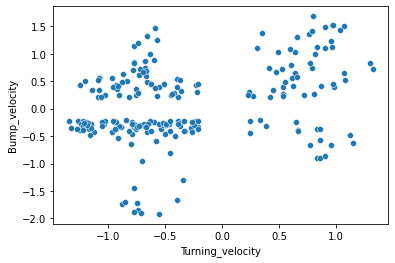

In [85]:
velocity_correlation_processed = pd.DataFrame()
velocity_correlation_processed['Turning_velocity'] = cc_turningVel_dff_BB_cleared
velocity_correlation_processed['Bump_velocity'] = cc_PVAVel_dff_BB_cleared
sns.scatterplot(data = velocity_correlation_processed, y = 'Bump_velocity', x = 'Turning_velocity')

In [86]:
def shift_for_maximum_correlation(x, y, max_shift_frame):
    
    from scipy.signal import correlate
    from scipy.signal import correlation_lags

    correlation = correlate(x, y, mode="full")
    lags = correlation_lags(x.size, y.size, mode="full")
                                  
    #find the middle index to consider the frame on both side till max shift frame (1s)
    middle_index = int(len(lags)/2)
    lags_short = lags[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
    correlation_short = correlation[(middle_index - max_shift_frame):(middle_index + max_shift_frame + 1) ]
    lag = lags_short[np.argmax(correlation_short)]
    #Lag > 0 means turning velocity is being shifted back and vice versa.
    if lag < 0:
        y = y.iloc[abs(lag):].reset_index(drop=True)
    else:
        x = x.iloc[lag:].reset_index(drop=True)
    return x, y, lag

In [87]:
velocity_df['Turning Velocity'] = Heading_vel_avt
velocity_df['PVA Velocity'] = PVA_vel_avt

Text(0.5, 1.0, 'Correlation after shifting,lag equals -0.41552999999999995 s, R = 0.19216709392816744')

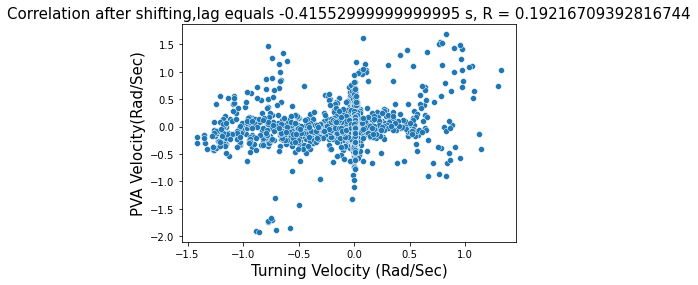

In [88]:
shifted_x, shifted_y, lagframe = shift_for_maximum_correlation(velocity_df['Turning Velocity'], velocity_df['PVA Velocity'], max_shift_frame = round(volume_rate)-1) 
shortest = min(shifted_x.shape[0], shifted_y.shape[0])
np.corrcoef(shifted_x.iloc[:shortest].values, shifted_y.iloc[:shortest].values)[0, 1]
velocity_crosscorrelated = pd.concat([shifted_x.iloc[:shortest], shifted_y.iloc[:shortest]], axis=1, join='inner')
import seaborn as sns
sns.scatterplot(data = velocity_crosscorrelated, x='Turning Velocity', y='PVA Velocity')
plt.xlabel('Turning Velocity (Rad/Sec)', fontsize = 15)
plt.ylabel('PVA Velocity(Rad/Sec)', fontsize = 15)  
plt.title(f"Correlation after shifting,lag equals {lagframe * volume_time} s, R = {np.corrcoef(shifted_x.iloc[:shortest].values, shifted_y.iloc[:shortest].values)[0, 1]}", fontsize = 15)

In [89]:
if lagframe < 0:
    bump_amplitude_dff_green_shifted = velocity_df['PVA Amplitude_green'].iloc[abs(lagframe):].reset_index(drop=True)
else:
    bump_amplitude_dff_green_shifted = velocity_df['PVA Amplitude_green']
bump_amplitude_dff_green_shifted = bump_amplitude_dff_green_shifted.iloc[:shortest].values

In [90]:
#Maximum velocity 500 degree/s in radians (8,72)
turningVel_threshold_up = np.pi * 2
pvaVel_threshold_up = np.pi* 2
#About 12 degrees/s in radians transformed from green 1mm/s on 6.35mm diameter ball
turningVel_threshold_down = 0.21
pvaVel_threshold_down = 0.21
amplitude_threshold = 0.8

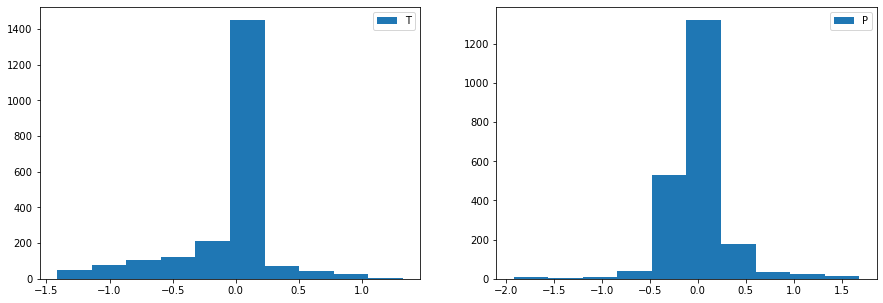

In [91]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
ax = axs[0]
ax.hist(shifted_x.iloc[:shortest].values)
ax.legend('Turning Velocity')
ax = axs[1]
ax.hist(shifted_y.iloc[:shortest].values)
ax.legend('PVA Velocity')

In [92]:
cross_correlated_turning_velocity_dff_both_Bridges = shifted_x.iloc[:shortest].values
cross_correlated_PVA_velocity_dff_both_Bridges = shifted_y.iloc[:shortest].values
cc_turningVel_dff_BB_cleared = []
cc_PVAVel_dff_BB_cleared = []
for i in range(len(cross_correlated_turning_velocity_dff_both_Bridges)):
    if np.abs(cross_correlated_turning_velocity_dff_both_Bridges[i]) > turningVel_threshold_down and np.abs(cross_correlated_PVA_velocity_dff_both_Bridges[i]) > pvaVel_threshold_down and np.abs(cross_correlated_turning_velocity_dff_both_Bridges[i]) < turningVel_threshold_up and np.abs(cross_correlated_PVA_velocity_dff_both_Bridges[i]) < pvaVel_threshold_up and bump_amplitude_dff_green_shifted[i] > amplitude_threshold:
        cc_turningVel_dff_BB_cleared.append(cross_correlated_turning_velocity_dff_both_Bridges[i])
        cc_PVAVel_dff_BB_cleared.append(cross_correlated_PVA_velocity_dff_both_Bridges[i])
    

In [93]:
np.corrcoef(cc_turningVel_dff_BB_cleared, cc_PVAVel_dff_BB_cleared)[0, 1]

0.8974798063456143

0.8974798063456143

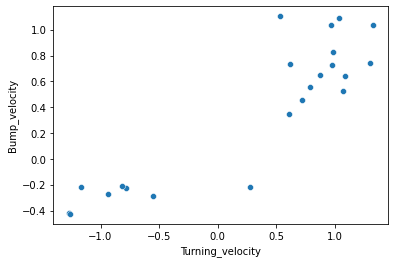

In [94]:
velocity_correlation_processed = pd.DataFrame()
velocity_correlation_processed['Turning_velocity'] = cc_turningVel_dff_BB_cleared
velocity_correlation_processed['Bump_velocity'] = cc_PVAVel_dff_BB_cleared
sns.scatterplot(data = velocity_correlation_processed, x = 'Turning_velocity', y = 'Bump_velocity',  palette = 'BuGn')
np.corrcoef(cc_turningVel_dff_BB_cleared, cc_PVAVel_dff_BB_cleared)[0, 1]

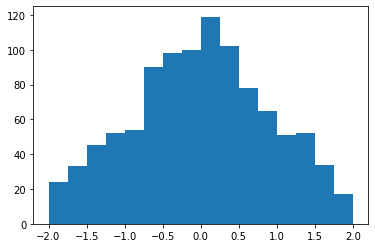

In [95]:
Heading_vel_degree = Heading_vel * 180/np.pi
plt.hist(Heading_vel_degree, bins='auto', range = (-2,2))
plt.show()

In [96]:
np.quantile(np.abs(Heading_vel_degree),0.05)

0.11510776189372514

In [97]:
PVA_behavior_data_output_original = pd.DataFrame()
PVA_behavior_data_output_original['Time_Stamp'] = time_array_imaging
PVA_behavior_data_output_original['F_Roi_1'] = F_8_roi[:,0]
PVA_behavior_data_output_original['F_Roi_2'] = F_8_roi[:,1]
PVA_behavior_data_output_original['F_Roi_3'] = F_8_roi[:,2]
PVA_behavior_data_output_original['F_Roi_4'] = F_8_roi[:,3]
PVA_behavior_data_output_original['F_Roi_5'] = F_8_roi[:,4]
PVA_behavior_data_output_original['F_Roi_6'] = F_8_roi[:,5]
PVA_behavior_data_output_original['F_Roi_7'] = F_8_roi[:,6]
PVA_behavior_data_output_original['F_Roi_8'] = F_8_roi[:,7]
PVA_behavior_data_output_original['dFF_Roi_1'] = dF_F_array_8_roi[:,0]
PVA_behavior_data_output_original['dFF_Roi_2'] = dF_F_array_8_roi[:,1]
PVA_behavior_data_output_original['dFF_Roi_3'] = dF_F_array_8_roi[:,2]
PVA_behavior_data_output_original['dFF_Roi_4'] = dF_F_array_8_roi[:,3]
PVA_behavior_data_output_original['dFF_Roi_5'] = dF_F_array_8_roi[:,4]
PVA_behavior_data_output_original['dFF_Roi_6'] = dF_F_array_8_roi[:,5]
PVA_behavior_data_output_original['dFF_Roi_7'] = dF_F_array_8_roi[:,6]
PVA_behavior_data_output_original['dFF_Roi_8'] = dF_F_array_8_roi[:,7]
PVA_behavior_data_output_original['PVA_Radian'] = PVA_radian_array
PVA_behavior_data_output_original['PVA_Radian_offset'] = PVA_radian_array_offset
PVA_behavior_data_output_original['PVA_Angle'] = PVA_angle_Array
PVA_behavior_data_output_original['Angular_Velocity'] = Heading_vel
PVA_behavior_data_output_original['Bar_Position/Heading'] = barPosition_array_downsampled_wrapped
PVA_behavior_data_output_original['Unwrapped_Bar_Position/Heading'] = heading_array_processed
PVA_behavior_data_output_original['Unwrapped_Radian'] = PVA_unwrapped
PVA_behavior_data_output_original['Integrated_x'] = fictrac_integrated_x_filtered_downsampled
PVA_behavior_data_output_original['Integrated_y'] = fictrac_integrated_y_filtered_downsampled
PVA_behavior_data_output_original['PVA_strength'] = PVA_strength
PVA_behavior_data_output_original['Bump_amplitude'] = bump_amplitude_dff

In [98]:
PVA_behavior_data_output_original.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/original/delta7_PB/TQfly028-006-imaging.csv',encoding = 'utf-8', index=False)

In [99]:
PVA_behavior_data_output_normalized = pd.DataFrame()
PVA_behavior_data_output_normalized['Time_Stamp'] = time_array_imaging
PVA_behavior_data_output_normalized['F_Roi_1'] = F_8_roi[:,0]
PVA_behavior_data_output_normalized['F_Roi_2'] = F_8_roi[:,1]
PVA_behavior_data_output_normalized['F_Roi_3'] = F_8_roi[:,2]
PVA_behavior_data_output_normalized['F_Roi_4'] = F_8_roi[:,3]
PVA_behavior_data_output_normalized['F_Roi_5'] = F_8_roi[:,4]
PVA_behavior_data_output_normalized['F_Roi_6'] = F_8_roi[:,5]
PVA_behavior_data_output_normalized['F_Roi_7'] = F_8_roi[:,6]
PVA_behavior_data_output_normalized['F_Roi_8'] = F_8_roi[:,7]
PVA_behavior_data_output_normalized['dFF_Roi_1'] = dF_F_array_8_roi_normalized[:,0]
PVA_behavior_data_output_normalized['dFF_Roi_2'] = dF_F_array_8_roi_normalized[:,1]
PVA_behavior_data_output_normalized['dFF_Roi_3'] = dF_F_array_8_roi_normalized[:,2]
PVA_behavior_data_output_normalized['dFF_Roi_4'] = dF_F_array_8_roi_normalized[:,3]
PVA_behavior_data_output_normalized['dFF_Roi_5'] = dF_F_array_8_roi_normalized[:,4]
PVA_behavior_data_output_normalized['dFF_Roi_6'] = dF_F_array_8_roi_normalized[:,5]
PVA_behavior_data_output_normalized['dFF_Roi_7'] = dF_F_array_8_roi_normalized[:,6]
PVA_behavior_data_output_normalized['dFF_Roi_8'] = dF_F_array_8_roi_normalized[:,7]
PVA_behavior_data_output_normalized['PVA_Radian'] = PVA_radian_array_normalized
PVA_behavior_data_output_normalized['PVA_Radian_offset'] = PVA_radian_array_normalized_offset
PVA_behavior_data_output_normalized['PVA_Angle'] = PVA_angle_Array_normalized
PVA_behavior_data_output_normalized['Angular_Velocity'] = Heading_vel
PVA_behavior_data_output_normalized['Bar_Position/Heading'] = barPosition_array_downsampled_wrapped
PVA_behavior_data_output_normalized['Unwrapped_Bar_Position/Heading'] = heading_array_processed
PVA_behavior_data_output_normalized['Unwrapped_Radian'] = PVA_unwrapped_normalized
PVA_behavior_data_output_normalized['Integrated_x'] = fictrac_integrated_x_filtered_downsampled
PVA_behavior_data_output_normalized['Integrated_y'] = fictrac_integrated_y_filtered_downsampled
PVA_behavior_data_output_normalized['PVA_strength'] = PVA_strength_normalized
PVA_behavior_data_output_normalized['Bump_amplitude'] = bump_amplitude_dff_normalized

In [100]:
PVA_angle_Array_normalized

array([ 94.56547121,  69.31760255,  32.32880506, ..., 120.03245126,
       115.79413685, 150.33229761])

In [101]:
PVA_behavior_data_output_normalized.to_csv('/home/tianhaoqiu/Documents/GitHub/2p_analysis/preprocessing_output/normalized/delta7_PB/TQfly028-006-imaging-normalized.csv',encoding = 'utf-8', index=False)